# 상태4종 2진분류 기울기 형성

In [26]:
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------------------------
# [설정] 컬럼명 및 파일 경로 설정
# --------------------------------------------------------------------------------
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# --------------------------------------------------------------------------------
# [함수] 기울기 및 점수 계산 로직
# --------------------------------------------------------------------------------
def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 6개월치 데이터를 받아 점수 계산"""
    # 데이터가 6개월 미만인 경우 0으로 채워서 반환
    if len(group) < 6:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    
    # 1. [부정] 악성 부채 점수 (Score_BadDebt)
    bad_debt_score = (
        ((group[COL_CASH_ADV].iloc[-1] - group[COL_CASH_ADV].iloc[-2]) / (group[COL_CASH_ADV].iloc[-2] + 1) * 1.5) +
        ((group[COL_CARD_LOAN].iloc[-1] - group[COL_CARD_LOAN].iloc[-2]) / (group[COL_CARD_LOAN].iloc[-2] + 1) * 1.0)
    )
    
    # 2. [부정] 연체 강도 점수 (Score_Delinq)
    delinq_score = (
        (group[COL_DELINQ].iloc[-1] * 3.0) +
        (group[COL_DELINQ].iloc[-2] * 2.0) +
        (group[COL_DELINQ].iloc[-3] * 1.0)
    )
    
    # 3. [긍정] 활동성 점수 (Score_Activity)
    sum_r3 = group[COL_COUNT].iloc[-3:].sum()
    sum_r6 = group[COL_COUNT].sum()
    activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
    
    # 4. [긍정] 자산 방어 점수 (Score_Asset)
    avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
    avg_r6 = group[COL_AVG_BAL].mean()
    asset_score = (avg_r3 / (avg_r6 + 1)) * 10
    
    # >> [Total] 상태 종합 점수 (Score_Status_Total)
    score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    
    # (B) 기울기 점수 (Slope Score)
    slope_spend = calc_slope_long(group[COL_SPEND])
    slope_balance = calc_slope_long(group[COL_BALANCE])
    slope_count = calc_slope_long(group[COL_COUNT])
    
    # [Final 파일과 동일한 컬럼 구성으로 반환]
    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

# =============================================================================
# [실행] 메인 프로세스
# =============================================================================

# 1. 데이터 로드
file_path = '../30만원본/GENERAL_30K_merged_data_240636_822.csv' 
print(f"파일을 로드합니다: {file_path}")
df = pd.read_csv(file_path)

# 2. 컬럼 순서 재배치 (발급회원번호 -> 기준년월 -> 나머지)
cols = df.columns.tolist()
if COL_ID in cols and COL_DATE in cols:
    remain_cols = [c for c in cols if c not in [COL_ID, COL_DATE]]
    df = df[[COL_ID, COL_DATE] + remain_cols]

# 3. 데이터 정렬 및 그룹별 연산
df.sort_values(by=[COL_ID, COL_DATE], inplace=True)

print("4. 고객별 지표 산출 중... (시간이 소요됩니다)")
# groupby 결과를 df에 할당 (고객 단위 데이터프레임)
df = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()

# 5. 점수 정규화 및 최종 산출
scaler = MinMaxScaler()

def normalize_risk_vector(series):
    series = series.replace([np.inf, -np.inf], 0).fillna(0)
    # 감소(-)하는 기울기만 위험으로 간주하여 양수로 변환
    risk = series.apply(lambda x: -x if x < 0 else 0)
    return scaler.fit_transform(risk.values.reshape(-1, 1)).flatten()

# 기울기 리스크 점수화 (Norm_...)
df['Norm_Slope_Spend'] = normalize_risk_vector(df['Slope_Spend'])
df['Norm_Slope_Balance'] = normalize_risk_vector(df['Slope_Balance'])
df['Norm_Slope_Count'] = normalize_risk_vector(df['Slope_Count'])

# 기울기 종합 점수 (Score_Slope_Total)
df['Score_Slope_Total'] = (
    (df['Norm_Slope_Spend'] * 40) +
    (df['Norm_Slope_Balance'] * 30) +
    (df['Norm_Slope_Count'] * 30)
)

# 상태 점수 Infinity 처리
df['Score_Status_Total'] = df['Score_Status_Total'].replace([np.inf, -np.inf], 0).fillna(0)

# 최종 합산 점수 (Final_Total_Score)
df['Final_Total_Score'] = (df['Score_Status_Total'] + df['Score_Slope_Total']) * 0.5

print("✅ 최종 작업 완료!")
# 결과 확인 (세부 점수 포함)
print(df[[COL_ID, 'Final_Total_Score', 'Score_Status_Total', 'Score_BadDebt', 'Score_Activity']].head())



파일을 로드합니다: ../30만원본/GENERAL_30K_merged_data_240636_822.csv


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2530321616.py:96: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


4. 고객별 지표 산출 중... (시간이 소요됩니다)


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2530321616.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100


✅ 최종 작업 완료!
        발급회원번호  Final_Total_Score  Score_Status_Total  Score_BadDebt  \
0  SYN_1000048         -10.674369          -21.348738            0.0   
1  SYN_1000194         -25.729657          -57.219573            0.0   
2  SYN_1000201          18.559508           26.484019            0.0   
3  SYN_1000250           1.822382            0.000000            0.0   
4  SYN_1000338          43.906651           79.781461            0.0   

   Score_Activity  
0       12.021858  
1       45.833333  
2      -37.209302  
3            -inf  
4      -91.666667  


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2530321616.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


### 파생변수 분포 확인

c:\Users\johnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


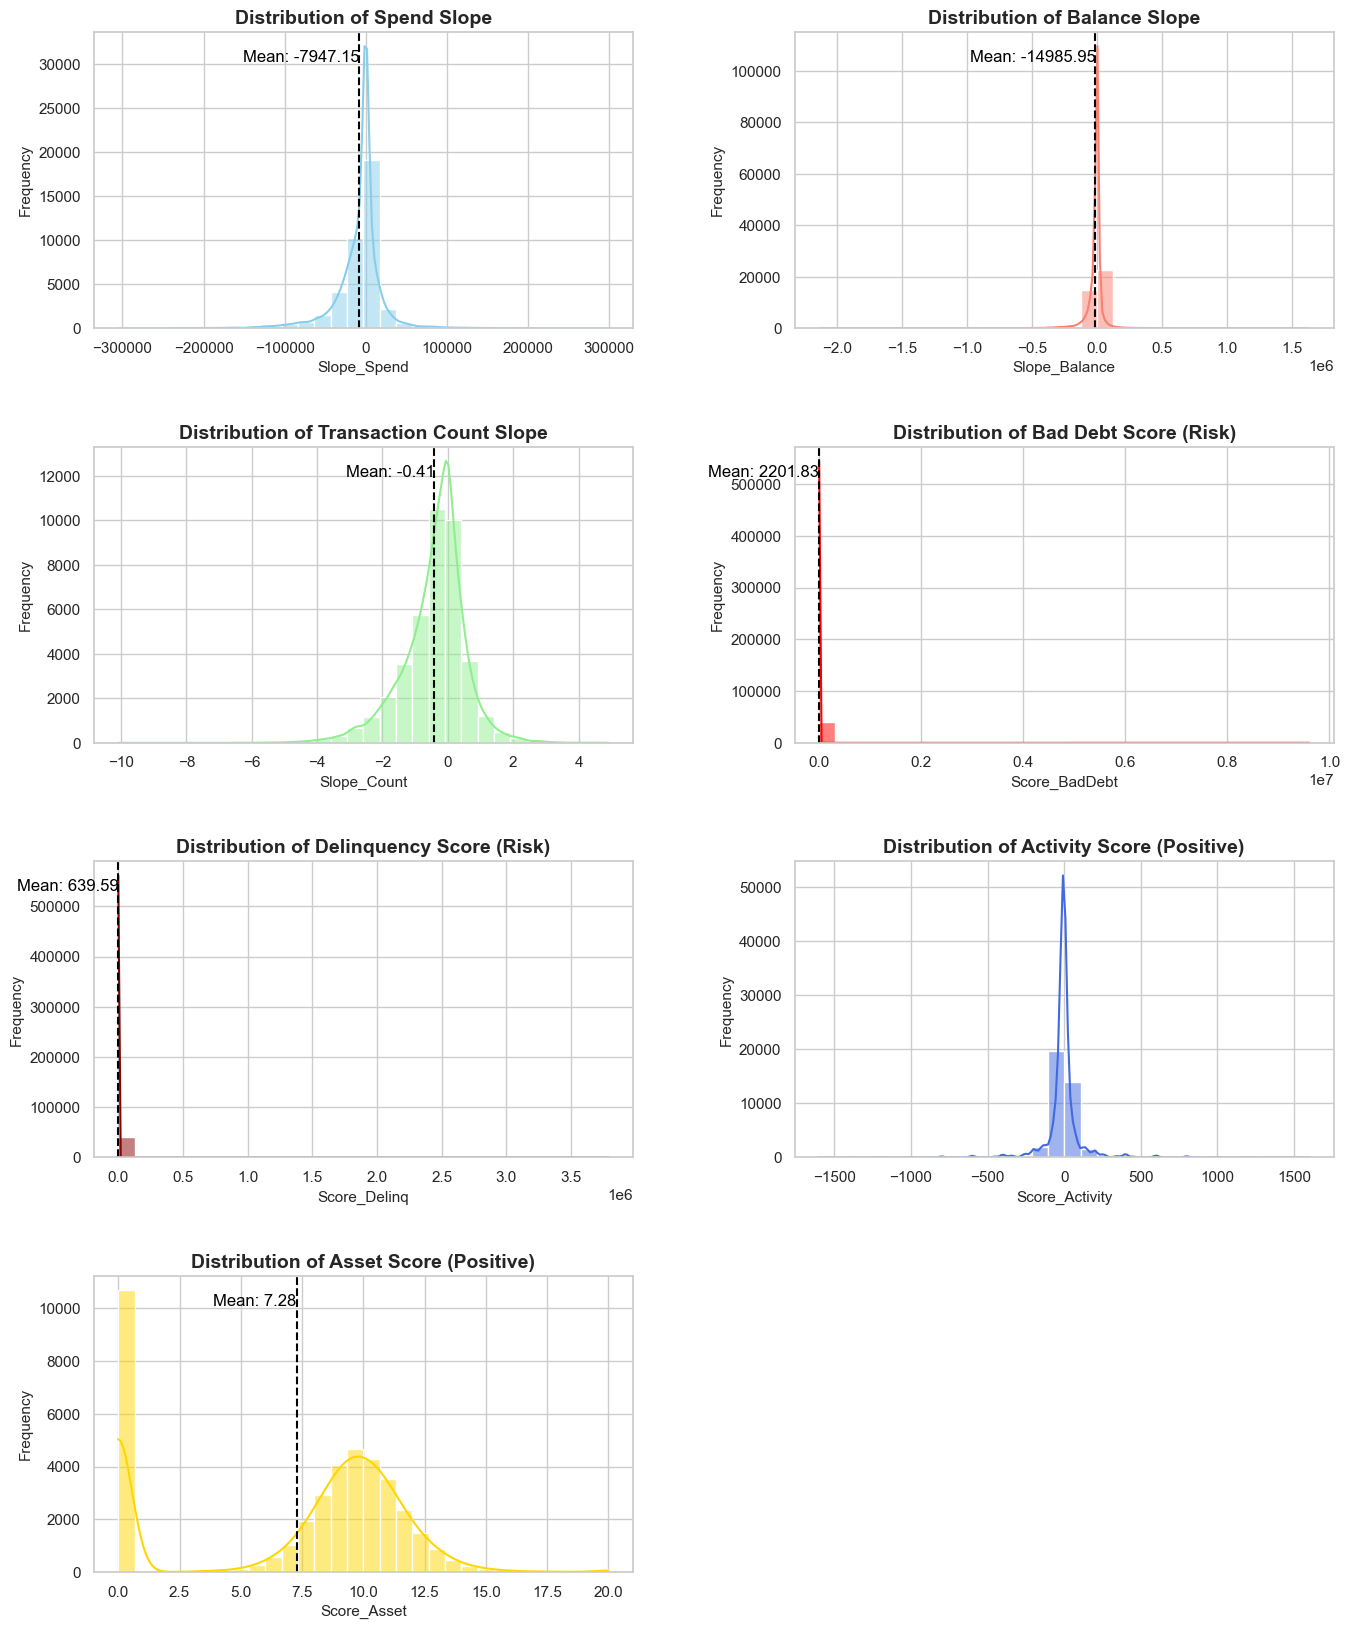

📊 7대 주요 지표 분포 시각화 완료


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# [시각화] 주요 변수 7종 분포 확인 (Visualization)
# =============================================================================

# 1. 그래프 스타일 및 캔버스 설정
sns.set(style="whitegrid")

# 4행 2열의 서브플롯 생성 (총 8개 공간, 7개 변수 사용)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3) # 그래프 간 간격 조정

# 변수 목록 및 제목 매핑
vars_to_plot = [
    ('Slope_Spend', 'Distribution of Spend Slope', 'skyblue'),
    ('Slope_Balance', 'Distribution of Balance Slope', 'salmon'),
    ('Slope_Count', 'Distribution of Transaction Count Slope', 'lightgreen'),
    ('Score_BadDebt', 'Distribution of Bad Debt Score (Risk)', 'red'),
    ('Score_Delinq', 'Distribution of Delinquency Score (Risk)', 'darkred'),
    ('Score_Activity', 'Distribution of Activity Score (Positive)', 'royalblue'),
    ('Score_Asset', 'Distribution of Asset Score (Positive)', 'gold')
]

# 2. 반복문을 통해 그래프 생성
flat_axes = axes.flatten() # 2차원 배열을 1차원으로 펼침

for i, (col, title, color) in enumerate(vars_to_plot):
    ax = flat_axes[i]
    
    # 히스토그램 & KDE(밀도) 그래프 그리기
    sns.histplot(data=df, x=col, kde=True, ax=ax, color=color, bins=30)
    
    # 그래프 꾸미기
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    
    # 평균선 추가 (점선)
    mean_val = df[col].mean()
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.5)
    ax.text(mean_val, ax.get_ylim()[1]*0.9, f'Mean: {mean_val:.2f}', color='black', ha='right')

# 3. 남는 칸(8번째) 숨기기 및 레이아웃 정리
if len(vars_to_plot) < len(flat_axes):
    for j in range(len(vars_to_plot), len(flat_axes)):
        fig.delaxes(flat_axes[j])

# 그래프 출력
plt.show()

print("📊 7대 주요 지표 분포 시각화 완료")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   발급회원번호              40106 non-null  object 
 1   Score_BadDebt       40106 non-null  float64
 2   Score_Delinq        40106 non-null  float64
 3   Score_Activity      40106 non-null  float64
 4   Score_Asset         40106 non-null  float64
 5   Score_Status_Total  40106 non-null  float64
 6   Slope_Spend         40106 non-null  float64
 7   Slope_Balance       40106 non-null  float64
 8   Slope_Count         40106 non-null  float64
 9   Norm_Slope_Spend    40106 non-null  float64
 10  Norm_Slope_Balance  40106 non-null  float64
 11  Norm_Slope_Count    40106 non-null  float64
 12  Score_Slope_Total   40106 non-null  float64
 13  Final_Total_Score   40106 non-null  float64
dtypes: float64(13), object(1)
memory usage: 4.3+ MB


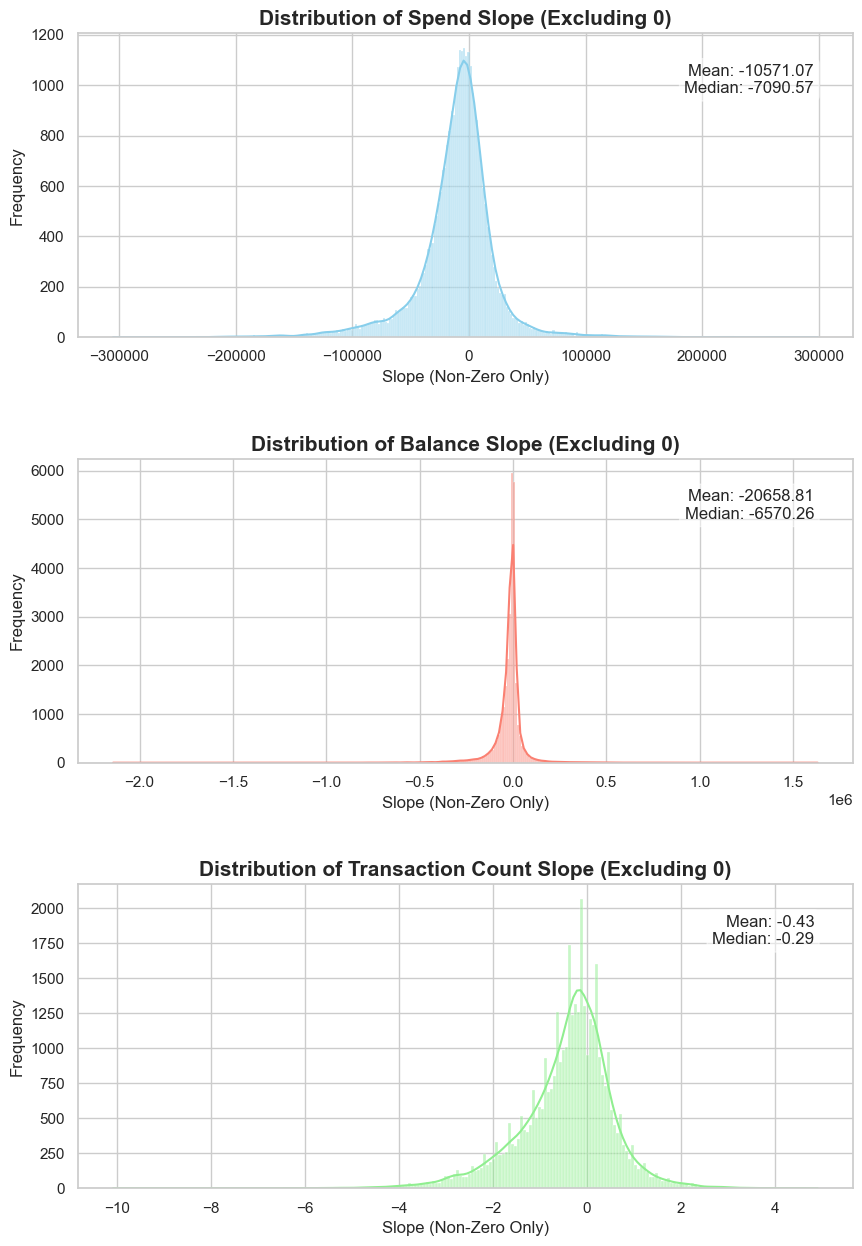

📊 0값 제외 그래프 생성이 완료되었습니다.
   - 전체 데이터 수: 40106
   - 0 제외 데이터 수 확인:
     * Slope_Spend: 30151 건 (0값: 9955 건)
     * Slope_Balance: 29093 건 (0값: 11013 건)
     * Slope_Count: 38801 건 (0값: 1305 건)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# [Step 5] 0값 제외(Zero-Excluded) 기울기 분포 시각화
# =============================================================================

# 1. 스타일 설정
sns.set(style="whitegrid")

# 2. 캔버스 생성 (3행 1열)
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.4)

# 분석할 변수와 제목 리스트 정의
slope_vars = [
    ('Slope_Spend', 'Spend Slope (Excluding 0)', 'skyblue'),
    ('Slope_Balance', 'Balance Slope (Excluding 0)', 'salmon'),
    ('Slope_Count', 'Transaction Count Slope (Excluding 0)', 'lightgreen')
]

for i, (col, title, color) in enumerate(slope_vars):
    # ---------------------------------------------------------
    # 핵심 로직: 값이 0이 아닌 데이터만 필터링
    # ----------------------------------------- ----------------
    data_nonzero = df[df[col] != 0]
    
    # 데이터가 비어있지 않은 경우에만 플롯
    if not data_nonzero.empty:
        sns.histplot(data=data_nonzero, x=col, kde=True, ax=axes[i], color=color)
        
        # 제목 및 축 설정
        axes[i].set_title(f'Distribution of {title}', fontsize=15, fontweight='bold')
        axes[i].set_xlabel('Slope (Non-Zero Only)', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        
        # 통계량 표시 (평균, 중앙값) - 그래프 안에 텍스트로 추가
        mean_val = data_nonzero[col].mean()
        median_val = data_nonzero[col].median()
        stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}'
        
        # 텍스트 박스 추가 (그래프 우측 상단)
        axes[i].text(0.95, 0.9, stats_text, transform=axes[i].transAxes, 
                     fontsize=12, verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    else:
        axes[i].text(0.5, 0.5, 'No Non-Zero Data', horizontalalignment='center', verticalalignment='center')
        axes[i].set_title(f'Distribution of {title}', fontsize=15, fontweight='bold')

# 3. 저장 및 출력
# plt.savefig('Slope_Distributions_NonZero.png', dpi=300)
plt.show()

print(f"📊 0값 제외 그래프 생성이 완료되었습니다.\n   - 전체 데이터 수: {len(df)}\n   - 0 제외 데이터 수 확인:")
for col, _, _ in slope_vars:
    print(f"     * {col}: {len(df[df[col] != 0])} 건 (0값: {len(df[df[col] == 0])} 건)")

In [5]:
# =============================================================================
# [Step 6] 기울기 감소/유지(<=0) 비율 확인
# =============================================================================

total_count = len(df)
print(f"📊 전체 데이터 수: {total_count:,}건\n")

# 1. 소비(Spend) 기울기 0 이하 비율
cnt_spend_le0 = len(df[df['Slope_Spend'] <= 0])
ratio_spend = (cnt_spend_le0 / total_count) * 100
print(f"1. 소비 감소/유지 (Spend <= 0): {ratio_spend:.2f}% ({cnt_spend_le0:,}건)")

# 2. 잔액(Balance) 기울기 0 이하 비율
cnt_balance_le0 = len(df[df['Slope_Balance'] <= 0])
ratio_balance = (cnt_balance_le0 / total_count) * 100
print(f"2. 잔액 감소/유지 (Balance <= 0): {ratio_balance:.2f}% ({cnt_balance_le0:,}건)")

# 3. 빈도(Count) 기울기 0 이하 비율
cnt_count_le0 = len(df[df['Slope_Count'] <= 0])
ratio_count = (cnt_count_le0 / total_count) * 100
print(f"3. 빈도 감소/유지 (Count <= 0) : {ratio_count:.2f}% ({cnt_count_le0:,}건)")

print("-" * 50)

# 4. [핵심] 3가지 지표 모두 0 이하인 경우 (교집합)
# 이들은 소비도 줄고, 잔액도 줄고, 발길(빈도)도 끊고 있는 '완전 이탈 징후' 고객군입니다.
df_all_le0 = df[
    (df['Slope_Spend'] <= 0) & 
    (df['Slope_Balance'] <= 0) & 
    (df['Slope_Count'] <= 0)
]
cnt_all_le0 = len(df_all_le0)
ratio_all = (cnt_all_le0 / total_count) * 100

print(f"🚨 4. 3가지 모두 감소/유지 (All <= 0): {ratio_all:.2f}% ({cnt_all_le0:,}건)")

📊 전체 데이터 수: 40,106건

1. 소비 감소/유지 (Spend <= 0): 73.42% (29,447건)
2. 잔액 감소/유지 (Balance <= 0): 74.98% (30,071건)
3. 빈도 감소/유지 (Count <= 0) : 67.62% (27,119건)
--------------------------------------------------
🚨 4. 3가지 모두 감소/유지 (All <= 0): 44.09% (17,684건)


In [6]:
# =============================================================================
# [Step A] 활동성 점수(Score_Activity) 분포 및 분위수 진단
# =============================================================================

# 1. 분위수(Quantile) 통계량 계산
# 하위 10%부터 50%까지 10% 단위로 끊어서 점수 확인
pct_range = [0.1, 0.2, 0.3, 0.4, 0.5]
quantiles_all = df['Score_Activity'].quantile(pct_range)

print("\n[전체 데이터 기준 하위 % 점수]")
for q, val in zip(pct_range, quantiles_all):
    print(f" - 하위 {int(q*100)}%: {val:.2f} 점")

# 감소한 사람(음수)들 중에서만 다시 분위수 확인 (더 정밀한 타겟팅용)
df_neg = df[df['Score_Activity'] < 0]
if not df_neg.empty:
    quantiles_neg = df_neg['Score_Activity'].quantile(pct_range)
    print("\n[활동성 감소(음수) 집단 내 하위 % 점수]")
    for q, val in zip(pct_range, quantiles_neg):
        print(f" - 하위 {int(q*100)}%: {val:.2f} 점")
else:
    quantiles_neg = []
    print("\n⚠️ 활동성 점수가 음수인 데이터가 없습니다.")

# #---------------------------------------------------------
# # 2. 시각화 (Visualization)
# # ---------------------------------------------------------
# sns.set(style="whitegrid")
# fig, axes = plt.subplots(2, 1, figsize=(12, 14))
# plt.subplots_adjust(hspace=0.4)

# # (1) 전체 분포 확인
# sns.histplot(data=df, x='Score_Activity', kde=True, ax=axes[0], color='royalblue', bins=50)
# axes[0].set_title('1. Distribution of Activity Score (All Customers)', fontsize=15, fontweight='bold')
# axes[0].set_xlabel('Score', fontsize=12)

# # 전체 기준 분위수 라인 표시
# for q, val in zip(pct_range, quantiles_all):
#     axes[0].axvline(val, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
#     axes[0].text(val, axes[0].get_ylim()[1]*0.95, f'{int(q*100)}%', color='red', ha='right', fontweight='bold', rotation=90)


# # (2) 감소 집단(음수) 상세 분포 확인 (Zoom-In)
# if not df_neg.empty:
#     sns.histplot(data=df_neg, x='Score_Activity', kde=True, ax=axes[1], color='darkorange', bins=30)
#     axes[1].set_title('2. Distribution of Activity Drop (Negative Score Only)', fontsize=15, fontweight='bold')
#     axes[1].set_xlabel('Negative Score (Drop Intensity)', fontsize=12)

#     # 음수 집단 기준 분위수 라인 표시
#     for q, val in zip(pct_range, quantiles_neg):
#         axes[1].axvline(val, color='darkred', linestyle='--', linewidth=1.5, alpha=0.7)
#         axes[1].text(val, axes[1].get_ylim()[1]*0.95, f'Bottom {int(q*100)}%', color='darkred', ha='right', fontweight='bold', rotation=90)
        
#     # 통계 박스 추가
#     stats_txt = f'Count: {len(df_neg):,}\nMean: {df_neg["Score_Activity"].mean():.2f}\nMin: {df_neg["Score_Activity"].min():.2f}'
#     axes[1].text(0.02, 0.95, stats_txt, transform=axes[1].transAxes, fontsize=12,
#                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# else:
#     axes[1].text(0.5, 0.5, "No Negative Score Data", ha='center', fontsize=15)

# # 저장 및 출력
# # plt.savefig('Activity_Score_Quantile_Analysis.png', dpi=300)
# plt.show()

# print("📊 그래프가 생성되었습니다. 붉은 점선이 하위 % 지점입니다.")


[전체 데이터 기준 하위 % 점수]
 - 하위 10%: -83.33 점
 - 하위 20%: -36.36 점
 - 하위 30%: -19.17 점
 - 하위 40%: -10.65 점
 - 하위 50%: -4.62 점

[활동성 감소(음수) 집단 내 하위 % 점수]
 - 하위 10%: -160.00 점
 - 하위 20%: -70.11 점
 - 하위 30%: -42.59 점
 - 하위 40%: -28.57 점
 - 하위 50%: -20.69 점


### True/False Decision Tree 생성

In [7]:
# (안전장치) df_all_le0가 정의되어 있는지 확인
# if 'df_all_le0' not in locals():
#     print("⚠️ df_all_le0 데이터를 다시 생성합니다.")
#     df_all_le0 = df[
#         (df['Slope_Spend'] <= 0) & 
#         (df['Slope_Balance'] <= 0) & 
#         (df['Slope_Count'] <= 0)
#     ].copy()

# print(f"대상 데이터 수: {len(df_all_le0):,}명")
# print("-" * 50)

# =============================================================================
# [Step 1] 조건 Flag 생성 (True = Risk/Signal 로 통일)
# =============================================================================

# 1. [반전] 악성 부채 점수가 있는가? (0이 아니면 True)
# -> 부채가 급증했거나(양수), 급감(음수)하는 등 변동이 있는 상태
df_all_le0['Cond1_Has_BadDebt'] = df_all_le0['Score_BadDebt'] > 0

# 2. [반전] 연체 점수가 있는가? (0이 아니면 True)
# -> 연체가 조금이라도 있는 상태
df_all_le0['Cond2_Has_Delinq'] = df_all_le0['Score_Delinq'] > 0

# 3. [유지] 활동성이 감소했는가? (음수면 True)
df_all_le0['Cond3_Activity_Drop'] = df_all_le0['Score_Activity'] < 0

# 4. [유지] 자산 점수가 0인가? (0이면 True)
df_all_le0['Cond4_Asset_Zero'] = df_all_le0['Score_Asset'] == 0


# =============================================================================
# [Step 2] 고객 유형 세분화 (Segmentation)
# =============================================================================

def classify_churn_type_v2(row):
    # 논리가 'True = 위험'으로 바뀌었으므로 코드가 더 직관적으로 변함
    
    # 1순위: 부실/연체 위험군 (악성부채나 연체 점수가 '있으면' 해당)
    if row['Cond1_Has_BadDebt'] or row['Cond2_Has_Delinq']:
        return '1. 부실/연체 위험군 (Risk)'
    
    # 2순위: 이탈 완료 의심군 (자산 점수가 0이면 해당)
    if row['Cond4_Asset_Zero']:
        return '2. 이탈 완료 의심군 (Empty Asset)'
    
    # 3순위: 활동성 급감군 (활동성 점수가 음수이면 해당)
    if row['Cond3_Activity_Drop']:
        return '3. 활동성 급감군 (Activity Drop)'
    
    # 4순위: 그 외 (기울기는 줄었지만, 위 3가지 심각한 징후는 없는 경우)
    return '4. 단순 감소/유지군 (Soft Decline)'

# 분류 적용
df_all_le0['Churn_Segment'] = df_all_le0.apply(classify_churn_type_v2, axis=1)

# =============================================================================
# [Step 3] 결과 집계
# =============================================================================

# 1. 각 Risk 조건별 감지 인원 (True 개수)
print("\n[Risk 요인별 감지 인원 (True 기준)]")
print(f"1. 악성부채 징후 (Score!=0) : {df_all_le0['Cond1_Has_BadDebt'].sum():,}명")
print(f"2. 연체 징후 (Score!=0)     : {df_all_le0['Cond2_Has_Delinq'].sum():,}명")
print(f"3. 활동성 감소 (Score<0)    : {df_all_le0['Cond3_Activity_Drop'].sum():,}명")
print(f"4. 자산 이탈 (Score=0)      : {df_all_le0['Cond4_Asset_Zero'].sum():,}명")

# 2. 최종 세그먼트 분포
segment_counts = df_all_le0['Churn_Segment'].value_counts()
segment_ratio = df_all_le0['Churn_Segment'].value_counts(normalize=True) * 100

print("\n[최종 고객 유형 분류 결과]")
result_df = pd.DataFrame({'인원수': segment_counts, '비율(%)': segment_ratio})
# 인덱스 정렬 (1번 그룹부터 순서대로 보이게)
result_df = result_df.sort_index()
print(result_df)

# 샘플 데이터 확인
print("\n[데이터 샘플]")
cols_check = ['발급회원번호', 'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero', 'Churn_Segment']
print(df_all_le0[cols_check].head())


[Risk 요인별 감지 인원 (True 기준)]
1. 악성부채 징후 (Score!=0) : 352명
2. 연체 징후 (Score!=0)     : 12명
3. 활동성 감소 (Score<0)    : 12,048명
4. 자산 이탈 (Score=0)      : 5,881명

[최종 고객 유형 분류 결과]
                              인원수      비율(%)
Churn_Segment                               
1. 부실/연체 위험군 (Risk)           363   2.052703
2. 이탈 완료 의심군 (Empty Asset)   5880  33.250396
3. 활동성 급감군 (Activity Drop)   9673  54.699163
4. 단순 감소/유지군 (Soft Decline)  1768   9.997738

[데이터 샘플]
         발급회원번호  Cond1_Has_BadDebt  Cond2_Has_Delinq  Cond3_Activity_Drop  \
2   SYN_1000201              False             False                 True   
3   SYN_1000250              False             False                 True   
4   SYN_1000338              False             False                 True   
8    SYN_100058              False             False                 True   
14  SYN_1000994              False             False                 True   

    Cond4_Asset_Zero               Churn_Segment  
2              False  3. 활동성 급감군 (A

C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1414906714.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_le0['Cond1_Has_BadDebt'] = df_all_le0['Score_BadDebt'] > 0
C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1414906714.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_le0['Cond2_Has_Delinq'] = df_all_le0['Score_Delinq'] > 0
C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1414906714.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [8]:
# =============================================================================
# [Step 4] 위험 요인 개수 산출 (Risk Intensity Scoring)
# =============================================================================

# 4가지 조건 컬럼 리스트
risk_cols = ['Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero']

# 행(Row)별로 True(1)의 개수를 합산
df_all_le0['Risk_Count'] = df_all_le0[risk_cols].sum(axis=1)

# 결과 확인
print("\n[위험 요인 개수별 인원 분포]")
count_dist = df_all_le0['Risk_Count'].value_counts().sort_index()
print(count_dist)

print("\n[비율(%)]")
print((df_all_le0['Risk_Count'].value_counts(normalize=True).sort_index() * 100).round(2))

# 샘플 데이터 확인 (잘 들어갔는지)
print("\n[데이터 샘플]")
print(df_all_le0[['발급회원번호', 'Risk_Count', 'Churn_Segment']].head())


[위험 요인 개수별 인원 분포]
Risk_Count
0     1768
1    13540
2     2375
3        1
Name: count, dtype: int64

[비율(%)]
Risk_Count
0    10.00
1    76.57
2    13.43
3     0.01
Name: proportion, dtype: float64

[데이터 샘플]
         발급회원번호  Risk_Count               Churn_Segment
2   SYN_1000201           1  3. 활동성 급감군 (Activity Drop)
3   SYN_1000250           1  3. 활동성 급감군 (Activity Drop)
4   SYN_1000338           1  3. 활동성 급감군 (Activity Drop)
8    SYN_100058           1  3. 활동성 급감군 (Activity Drop)
14  SYN_1000994           1  3. 활동성 급감군 (Activity Drop)


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1207309625.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_le0['Risk_Count'] = df_all_le0[risk_cols].sum(axis=1)


### Target 형성 (이탈자)

In [9]:
df_all_le0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17684 entries, 2 to 40105
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   발급회원번호               17684 non-null  object 
 1   Score_BadDebt        17684 non-null  float64
 2   Score_Delinq         17684 non-null  float64
 3   Score_Activity       17684 non-null  float64
 4   Score_Asset          17684 non-null  float64
 5   Score_Status_Total   17684 non-null  float64
 6   Slope_Spend          17684 non-null  float64
 7   Slope_Balance        17684 non-null  float64
 8   Slope_Count          17684 non-null  float64
 9   Norm_Slope_Spend     17684 non-null  float64
 10  Norm_Slope_Balance   17684 non-null  float64
 11  Norm_Slope_Count     17684 non-null  float64
 12  Score_Slope_Total    17684 non-null  float64
 13  Final_Total_Score    17684 non-null  float64
 14  Cond1_Has_BadDebt    17684 non-null  bool   
 15  Cond2_Has_Delinq     17684 non-null  bool

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   발급회원번호              40106 non-null  object 
 1   Score_BadDebt       40106 non-null  float64
 2   Score_Delinq        40106 non-null  float64
 3   Score_Activity      40106 non-null  float64
 4   Score_Asset         40106 non-null  float64
 5   Score_Status_Total  40106 non-null  float64
 6   Slope_Spend         40106 non-null  float64
 7   Slope_Balance       40106 non-null  float64
 8   Slope_Count         40106 non-null  float64
 9   Norm_Slope_Spend    40106 non-null  float64
 10  Norm_Slope_Balance  40106 non-null  float64
 11  Norm_Slope_Count    40106 non-null  float64
 12  Score_Slope_Total   40106 non-null  float64
 13  Final_Total_Score   40106 non-null  float64
dtypes: float64(13), object(1)
memory usage: 4.3+ MB


#### df 에 Risk_Count 추가

In [11]:
# (안전장치) df_all_le0가 정의되어 있는지 확인
# if 'df_all_le0' not in locals():
#     print("⚠️ df_all_le0 데이터를 다시 생성합니다.")
#     df_all_le0 = df[
#         (df['Slope_Spend'] <= 0) & 
#         (df['Slope_Balance'] <= 0) & 
#         (df['Slope_Count'] <= 0)
#     ].copy()

# print(f"대상 데이터 수: {len(df_all_le0):,}명")
# print("-" * 50)

# =============================================================================
# [Step 1] 조건 Flag 생성 (True = Risk/Signal 로 통일)
# =============================================================================

# 1. [반전] 악성 부채 점수가 있는가? (0이 아니면 True)
# -> 부채가 급증했거나(양수), 급감(음수)하는 등 변동이 있는 상태
df['Cond1_Has_BadDebt'] = df['Score_BadDebt'] > 0

# 2. [반전] 연체 점수가 있는가? (0이 아니면 True)
# -> 연체가 조금이라도 있는 상태
df['Cond2_Has_Delinq'] = df['Score_Delinq'] > 0

# 3. [유지] 활동성이 감소했는가? (음수면 True)
df['Cond3_Activity_Drop'] = df['Score_Activity'] < 0

# 4. [유지] 자산 점수가 0인가? (0이면 True)
df['Cond4_Asset_Zero'] = df['Score_Asset'] == 0


# =============================================================================
# [Step 2] 고객 유형 세분화 (Segmentation)
# =============================================================================

def classify_churn_type_v2(row):
    # 논리가 'True = 위험'으로 바뀌었으므로 코드가 더 직관적으로 변함
    
    # 1순위: 부실/연체 위험군 (악성부채나 연체 점수가 '있으면' 해당)
    if row['Cond1_Has_BadDebt'] or row['Cond2_Has_Delinq']:
        return '1. 부실/연체 위험군 (Risk)'
    
    # 2순위: 이탈 완료 의심군 (자산 점수가 0이면 해당)
    if row['Cond4_Asset_Zero']:
        return '2. 이탈 완료 의심군 (Empty Asset)'
    
    # 3순위: 활동성 급감군 (활동성 점수가 음수이면 해당)
    if row['Cond3_Activity_Drop']:
        return '3. 활동성 급감군 (Activity Drop)'
    
    # 4순위: 그 외 (기울기는 줄었지만, 위 3가지 심각한 징후는 없는 경우)
    return '4. 단순 감소/유지군 (Soft Decline)'

# 분류 적용
df['Churn_Segment'] = df.apply(classify_churn_type_v2, axis=1)

# =============================================================================
# [Step 3] 결과 집계
# =============================================================================

# 1. 각 Risk 조건별 감지 인원 (True 개수)
print("\n[Risk 요인별 감지 인원 (True 기준)]")
print(f"1. 악성부채 징후 (Score!=0) : {df['Cond1_Has_BadDebt'].sum():,}명")
print(f"2. 연체 징후 (Score!=0)     : {df['Cond2_Has_Delinq'].sum():,}명")
print(f"3. 활동성 감소 (Score<0)    : {df['Cond3_Activity_Drop'].sum():,}명")
print(f"4. 자산 이탈 (Score=0)      : {df['Cond4_Asset_Zero'].sum():,}명")

# 2. 최종 세그먼트 분포
segment_counts = df['Churn_Segment'].value_counts()
segment_ratio = df['Churn_Segment'].value_counts(normalize=True) * 100

print("\n[최종 고객 유형 분류 결과]")
result_df = pd.DataFrame({'인원수': segment_counts, '비율(%)': segment_ratio})
# 인덱스 정렬 (1번 그룹부터 순서대로 보이게)
result_df = result_df.sort_index()
print(result_df)

# 샘플 데이터 확인
print("\n[데이터 샘플]")
cols_check = ['발급회원번호', 'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero', 'Churn_Segment']
print(df[cols_check].head())


[Risk 요인별 감지 인원 (True 기준)]
1. 악성부채 징후 (Score!=0) : 1,382명
2. 연체 징후 (Score!=0)     : 37명
3. 활동성 감소 (Score<0)    : 23,264명
4. 자산 이탈 (Score=0)      : 10,699명

[최종 고객 유형 분류 결과]
                               인원수      비율(%)
Churn_Segment                                
1. 부실/연체 위험군 (Risk)           1413   3.523164
2. 이탈 완료 의심군 (Empty Asset)   10697  26.671820
3. 활동성 급감군 (Activity Drop)   17696  44.123074
4. 단순 감소/유지군 (Soft Decline)  10300  25.681943

[데이터 샘플]
        발급회원번호  Cond1_Has_BadDebt  Cond2_Has_Delinq  Cond3_Activity_Drop  \
0  SYN_1000048              False             False                False   
1  SYN_1000194              False             False                False   
2  SYN_1000201              False             False                 True   
3  SYN_1000250              False             False                 True   
4  SYN_1000338              False             False                 True   

   Cond4_Asset_Zero                Churn_Segment  
0             False  4. 단순 감소/유지

In [12]:
# =============================================================================
# [Step 4] 위험 요인 개수 산출 (Risk Intensity Scoring)
# =============================================================================

# 4가지 조건 컬럼 리스트
risk_cols = ['Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero']

# 행(Row)별로 True(1)의 개수를 합산
df['Risk_Count'] = df[risk_cols].sum(axis=1)

# 결과 확인
print("\n[위험 요인 개수별 인원 분포]")
count_dist = df['Risk_Count'].value_counts().sort_index()
print(count_dist)

print("\n[비율(%)]")
print((df['Risk_Count'].value_counts(normalize=True).sort_index() * 100).round(2))

# 샘플 데이터 확인 (잘 들어갔는지)
print("\n[데이터 샘플]")
print(df[['발급회원번호', 'Risk_Count', 'Churn_Segment']].head())


[위험 요인 개수별 인원 분포]
Risk_Count
0    10300
1    24235
2     5566
3        5
Name: count, dtype: int64

[비율(%)]
Risk_Count
0    25.68
1    60.43
2    13.88
3     0.01
Name: proportion, dtype: float64

[데이터 샘플]
        발급회원번호  Risk_Count                Churn_Segment
0  SYN_1000048           0  4. 단순 감소/유지군 (Soft Decline)
1  SYN_1000194           0  4. 단순 감소/유지군 (Soft Decline)
2  SYN_1000201           1   3. 활동성 급감군 (Activity Drop)
3  SYN_1000250           1   3. 활동성 급감군 (Activity Drop)
4  SYN_1000338           1   3. 활동성 급감군 (Activity Drop)


✅ 교집합(AND) 조건이 적용된 Target 생성이 완료되었습니다!
전체 고객 수: 40,106명

[최종 Target 분포]
- 이탈 위험군 (Target=1): 2,376명 (5.9%)
- 일반군      (Target=2): 37,730명 (94.1%)
  └─ (참고) 조건A(기울기감소) 만족: 17,684명
  └─ (참고) 조건B(Risk>=2) 만족: 5,571명

[조건별 데이터 매트릭스]
Risk>=2(B)  False  True    All
기울기감소(A)                      
False       19227  3195  22422
True        15308  2376  17684
All         34535  5571  40106

[이탈 위험군(Target=1) 샘플 데이터]
         발급회원번호   Slope_Spend  Slope_Balance  Slope_Count  Risk_Count  Target
44  SYN_1002837 -22455.571429  -15294.628571    -0.885714           2       1
47  SYN_1002876      0.000000       0.000000    -0.628571           2       1
59  SYN_1003650 -12882.085714       0.000000    -1.257143           2       1
77  SYN_1004256      0.000000       0.000000    -0.342857           2       1
88  SYN_1004762  -5729.685714       0.000000    -0.542857           2       1


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\374321369.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Target', palette='coolwarm')


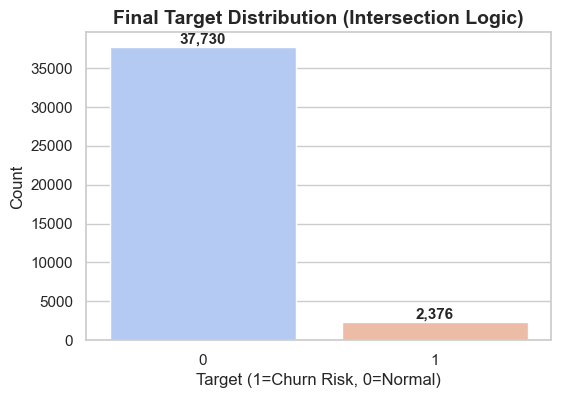

In [13]:
# =============================================================================
# [Logic Update] 교집합 조건(AND)을 적용한 정밀 타겟 생성
# =============================================================================

# 1. 조건 정의
# (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하인 경우 (df_all_le0 개념)
cond_slopes_decrease = (
    (df['Slope_Spend'] <= 0) & 
    (df['Slope_Balance'] <= 0) & 
    (df['Slope_Count'] <= 0)
)

# (조건 B) 4대 위험 징후 중 2개 이상 감지된 경우
cond_high_risk = (df['Risk_Count'] >= 2)

# 2. Target 생성 (교집합 적용)
# - 두 조건(A & B)을 모두 만족해야 이탈 위험군(1)
# - 하나라도 만족하지 않으면 일반군(0)
df['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)

# -----------------------------------------------------------------------------
# [검증] 결과 확인
# -----------------------------------------------------------------------------
print("✅ 교집합(AND) 조건이 적용된 Target 생성이 완료되었습니다!")
print(f"전체 고객 수: {len(df):,}명")

# 분포 확인
target_counts = df['Target'].value_counts().sort_index()
print("\n[최종 Target 분포]")
print(f"- 이탈 위험군 (Target=1): {target_counts.get(1, 0):,}명 ({target_counts.get(1, 0)/len(df)*100:.1f}%)")
print(f"- 일반군      (Target=2): {target_counts.get(0, 0):,}명 ({target_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"  └─ (참고) 조건A(기울기감소) 만족: {cond_slopes_decrease.sum():,}명")
print(f"  └─ (참고) 조건B(Risk>=2) 만족: {cond_high_risk.sum():,}명")

# 교차 검증 (Crosstab)
print("\n[조건별 데이터 매트릭스]")
print(pd.crosstab(cond_slopes_decrease, cond_high_risk, rownames=['기울기감소(A)'], colnames=['Risk>=2(B)'], margins=True))

# 샘플 데이터 확인 (Target=1인 경우만)
print("\n[이탈 위험군(Target=1) 샘플 데이터]")
print(df[df['Target']==1][['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Slope_Count', 'Risk_Count', 'Target']].head(5))

# =============================================================================
# [시각화] 최종 Target 분포 시각화
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Target', palette='coolwarm')
plt.title('Final Target Distribution (Intersection Logic)', fontsize=14, fontweight='bold')
plt.xlabel('Target (1=Churn Risk, 0=Normal)')
plt.ylabel('Count')

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

In [14]:
df['Target'].value_counts(normalize=True)

Target
0    0.940757
1    0.059243
Name: proportion, dtype: float64

### 타겟컬럼_원본컬럼 머지

In [16]:
df_1 = pd.read_csv(file_path)

C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\3076235782.py:1: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv(file_path)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   발급회원번호               40106 non-null  object 
 1   Score_BadDebt        40106 non-null  float64
 2   Score_Delinq         40106 non-null  float64
 3   Score_Activity       40106 non-null  float64
 4   Score_Asset          40106 non-null  float64
 5   Score_Status_Total   40106 non-null  float64
 6   Slope_Spend          40106 non-null  float64
 7   Slope_Balance        40106 non-null  float64
 8   Slope_Count          40106 non-null  float64
 9   Norm_Slope_Spend     40106 non-null  float64
 10  Norm_Slope_Balance   40106 non-null  float64
 11  Norm_Slope_Count     40106 non-null  float64
 12  Score_Slope_Total    40106 non-null  float64
 13  Final_Total_Score    40106 non-null  float64
 14  Cond1_Has_BadDebt    40106 non-null  bool   
 15  Cond2_Has_Delinq     40106 non-null 

In [18]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240636 entries, 0 to 240635
Columns: 822 entries, 기준년월 to 최종카드발급경과월
dtypes: float64(62), int64(728), object(32)
memory usage: 1.5+ GB


In [19]:
key_cols = ['발급회원번호']
df_2 = pd.merge(df,df_1, on=key_cols, how='inner')

In [20]:
df_2[['발급회원번호','Target']]

,발급회원번호,Target
0,SYN_1000048,0
1,SYN_1000048,0
2,SYN_1000048,0
3,SYN_1000048,0
4,SYN_1000048,0
...,...,...
240631,SYN_999995,0
240632,SYN_999995,0
240633,SYN_999995,0
240634,SYN_999995,0


# 변수중요도 확인 -> Feature Importance by LightGBM

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df = df_2

🧹 데이터 정리 중...
   - 초기 변수 개수: 800 개
   - 무의미한(값 고정) 컬럼 제거 후: 708 개
   - (제거된 컬럼 수: 92 개)

🚀 LightGBM 모델 학습 중... (RF보다 훨씬 빠릅니다)


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2027049700.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='Importance', y='Feature', palette='magma')


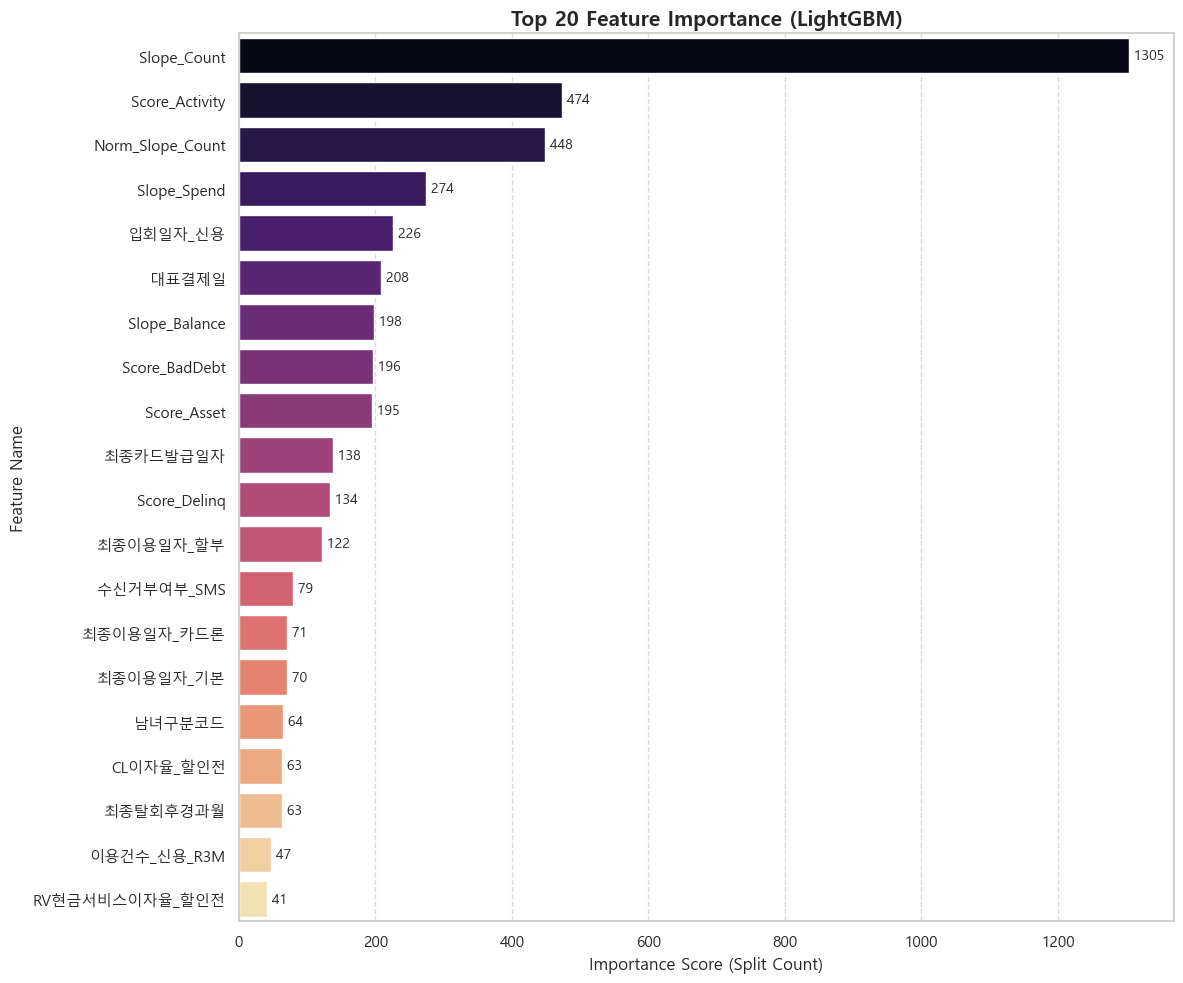

📊 분석 완료.
   - 최종 사용된 변수: 708 개
   - 상위 변수들이 이탈을 구분하는 데 가장 많이 사용되었습니다.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb  # Random Forest 대신 사용 (훨씬 빠름)


# 
# =============================================================================
# [Step 1] 데이터 다이어트 (전처리)
# =============================================================================
print("🧹 데이터 정리 중...")

# 1. 분석 제외 대상 컬럼 설정
# (식별자, 타겟, 이미 생성한 파생변수 결과값 등은 제외)
exclude_cols = ['발급회원번호', 'Target', 'Churn_Segment', 'Risk_Count',
                'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
                'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score']

# 2. 수치형 데이터만 우선 선택 (속도 및 에러 방지)
# 5000개 중 문자열(Object)이 섞여 있으면 인코딩하느라 시간이 오래 걸리므로, 일단 수치형 위주로 봅니다.
df_numeric = df.select_dtypes(include=[np.number])
X = df_numeric.drop(columns=[c for c in exclude_cols if c in df_numeric.columns], errors='ignore')
y = df['Target']

print(f"   - 초기 변수 개수: {X.shape[1]:,} 개")

# 무한대(inf)와 결측치(NaN)를 모두 0으로 안전하게 대체합니다.
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(0)

# 3. [핵심] 분산이 0인(모든 값이 똑같은) 컬럼 제거
# 예: 모든 고객의 '가입비'가 0원이라면, 이 변수는 분석 가치가 없습니다.
selector = VarianceThreshold(threshold=0)
selector.fit(X)

# 선택된 컬럼만 남기기
X_reduced = X.loc[:, selector.get_support()]

print(f"   - 무의미한(값 고정) 컬럼 제거 후: {X_reduced.shape[1]:,} 개")
print(f"   - (제거된 컬럼 수: {X.shape[1] - X_reduced.shape[1]:,} 개)")

# =============================================================================
# [Step 2] LightGBM으로 고속 학습
# =============================================================================
print("\n🚀 LightGBM 모델 학습 중... (RF보다 훨씬 빠릅니다)")

# LGBM 설정: 속도 위주 세팅
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,      # 나무의 개수
    learning_rate=0.1,     # 학습률
    num_leaves=31,         # 잎의 개수 (복잡도 제어)
    n_jobs=-1,             # 모든 CPU 코어 사용
    random_state=42,
    verbose=-1             # 경고 메시지 숨김
)

lgbm_model.fit(X_reduced, y)

# =============================================================================
# [Step 3] 중요도 시각화
# =============================================================================

# 중요도 추출
feature_imp = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': lgbm_model.feature_importances_
})

# 중요도 0인 변수 제외하고, 상위 20개 정렬
top_20_features = feature_imp[feature_imp['Importance'] > 0].sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(data=top_20_features, x='Importance', y='Feature', palette='magma')

plt.title('Top 20 Feature Importance (LightGBM)', fontsize=15, fontweight='bold')
plt.xlabel('Importance Score (Split Count)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 수치 텍스트 표시
for i, v in enumerate(top_20_features['Importance']):
    plt.text(v, i, f' {int(v)}', va='center', fontsize=10)

plt.tight_layout()
# plt.savefig('Feature_Importance_LightGBM.png', dpi=300)
plt.show()

print("📊 분석 완료.")
print(f"   - 최종 사용된 변수: {X_reduced.shape[1]:,} 개")
print("   - 상위 변수들이 이탈을 구분하는 데 가장 많이 사용되었습니다.")

In [23]:
feature_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Feature     708 non-null    object
 1   Importance  708 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 8.4+ KB


In [24]:
feature_imp['Importance'] = feature_imp['Importance'].sort_values(ascending=False, ignore_index=True)

In [25]:
feature_imp

,Feature,Importance
0,Score_BadDebt,1305
1,Score_Delinq,474
2,Score_Activity,448
3,Score_Asset,274
4,Slope_Spend,226
...,...,...
703,제휴연회비_B0M,0
704,청구금액_기본연회비_B0M,0
705,청구금액_제휴연회비_B0M,0
706,카드신청건수,0


In [26]:
df_2['Target'].value_counts(normalize=True)

Target
0    0.940757
1    0.059243
Name: proportion, dtype: float64

## Feature Importance 를 이용해 컬럼 추출

In [27]:
# =============================================================================
# [Step 6] Feature Selection (Top 100) - 메모리 반환 버전 (저장 X)
# =============================================================================

def select_top100_features(source_df, importance_df):
    print(f"[Process] Top 100 Feature 추출 시작 (메모리 내 처리)...")
    
    # ---------------------------------------------------------
    # 1. Feature Importance 필터링
    # ---------------------------------------------------------
    # (안전장치) 내림차순 정렬
    df_imp_sorted = importance_df.sort_values(by='Importance', ascending=False)
    
    # 조건: Importance > 0
    df_imp_active = df_imp_sorted[df_imp_sorted['Importance'] > 0]
    
    # 상위 100개 추출
    top_features = df_imp_active.head(100)['Feature'].tolist()
    
    print(f"  - 중요도 > 0 인 컬럼 수: {len(df_imp_active)}개")
    print(f"  - 최종 선정된 Feature 수 (Top 100): {len(top_features)}개")
    
    if len(top_features) == 0:
        print("  [!] 경고: 조건에 맞는 Feature가 없습니다.")
        return None

    # ---------------------------------------------------------
    # 2. 원본 데이터(source_df)에서 컬럼 선택
    # ---------------------------------------------------------
    # 필수 컬럼 정의 (Target, ID 등 분석에 꼭 필요한 컬럼)
    essential_cols = ['발급회원번호', 'Target']
    
    # 원본 데이터에 실제 존재하는 컬럼인지 확인 (KeyError 방지)
    valid_features = [col for col in top_features if col in source_df.columns]
    
    # 제외된 컬럼 확인
    missing_cols = set(top_features) - set(valid_features)
    if missing_cols:
        print(f"  [!] 주의: 원본 데이터에 없는 컬럼 {len(missing_cols)}개가 제외되었습니다.")
    
    # 최종 선택 컬럼 리스트 생성 (순서: 필수 -> 중요도순)
    final_cols = essential_cols + valid_features
    
    # 중복 제거 (필수 컬럼이 중요도 리스트에도 있을 경우 대비)
    final_cols = list(dict.fromkeys(final_cols))
    
    # ---------------------------------------------------------
    # 3. 데이터 슬라이싱 및 반환
    # ---------------------------------------------------------
    try:
        df_result = source_df[final_cols].copy()
        print(f"  ✅ 데이터 추출 완료. Shape: {df_result.shape}")
        return df_result
        
    except Exception as e:
        print(f"  [!] 추출 중 오류 발생: {e}")
        return None

# =============================================================================
# [실행]
# =============================================================================

# (안전장치) df_2 확인 (앞선 단계에서 Target이 병합된 데이터프레임)
if 'df_2' not in locals():
    if 'df' in locals():
        print("⚠ 'df_2'가 없어 현재 메모리의 'df'를 사용합니다.")
        df_2 = df.copy()
    else:
        print("⛔ 오류: 데이터프레임('df' 또는 'df_2')이 정의되지 않았습니다.")

# 함수 실행 (결과를 df_final 변수에 저장)
if 'feature_imp' in locals() and 'df_2' in locals():
    # 파일로 저장하지 않고, 변수(df_final)로 받아서 바로 사용
    df_final = select_top100_features(df_2, feature_imp)
    
    # 결과 확인
    if df_final is not None:
        print("\n[Result Sample]")
        print(df_final.head())
else:
    print("⛔ 'feature_imp' 변수(중요도 데이터프레임)가 정의되지 않았습니다.")

[Process] Top 100 Feature 추출 시작 (메모리 내 처리)...
  - 중요도 > 0 인 컬럼 수: 225개
  - 최종 선정된 Feature 수 (Top 100): 100개
  ✅ 데이터 추출 완료. Shape: (240636, 102)

[Result Sample]
        발급회원번호  Target  Score_BadDebt  Score_Delinq  Score_Activity  \
0  SYN_1000048       0            0.0           0.0       12.021858   
1  SYN_1000048       0            0.0           0.0       12.021858   
2  SYN_1000048       0            0.0           0.0       12.021858   
3  SYN_1000048       0            0.0           0.0       12.021858   
4  SYN_1000048       0            0.0           0.0       12.021858   

   Score_Asset   Slope_Spend  Slope_Balance  Slope_Count  Norm_Slope_Spend  \
0      9.32688  17871.228571        56172.4     1.942857               0.0   
1      9.32688  17871.228571        56172.4     1.942857               0.0   
2      9.32688  17871.228571        56172.4     1.942857               0.0   
3      9.32688  17871.228571        56172.4     1.942857               0.0   
4      9.32688  17871.

In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240636 entries, 0 to 240635
Columns: 102 entries, 발급회원번호 to 이용건수_부분무이자_R12M
dtypes: float64(57), int64(44), object(1)
memory usage: 187.3+ MB


## 모델 돌리기 - lightGBM

In [29]:
import pandas as pd

# 1. 모든 열(Column)을 다 보여주기 (생략 ... 방지)
pd.set_option('display.max_columns', None)

# 2. 모든 행(Row)을 다 보여주기 (데이터가 너무 많으면 브라우저가 느려질 수 있으니 주의)
# pd.set_option('display.max_rows', None)  # 필요할 때만 주석 해제해서 사용하세요

# 3. 컬럼 내의 텍스트가 길어도 자르지 않고 다 보여주기
pd.set_option('display.max_colwidth', None)

# 4. 가로 폭을 넓게 설정 (줄바꿈 방지)
pd.set_option('display.width', 1000)

print("✅ 출력 제한 옵션이 해제되었습니다.")

✅ 출력 제한 옵션이 해제되었습니다.



==================== [GENERAL] Training Start (Balanced) ====================
 - 학습 Feature 수: 90개
 - 학습 데이터 샘플 수: 240636개
✅ 학습 완료 (소요시간: 4.64초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.8562
 - F1 Score  : 0.8888
 - ROC-AUC   : 0.9416
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     45277
           1       0.28      0.91      0.43      2851

    accuracy                           0.86     48128
   macro avg       0.64      0.88      0.67     48128
weighted avg       0.95      0.86      0.89     48128



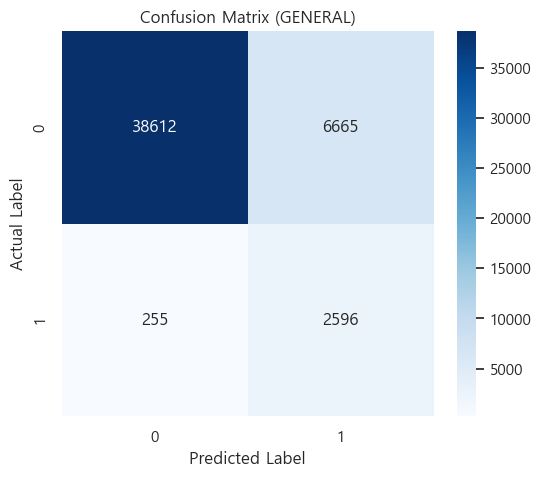

<Figure size 1000x800 with 0 Axes>

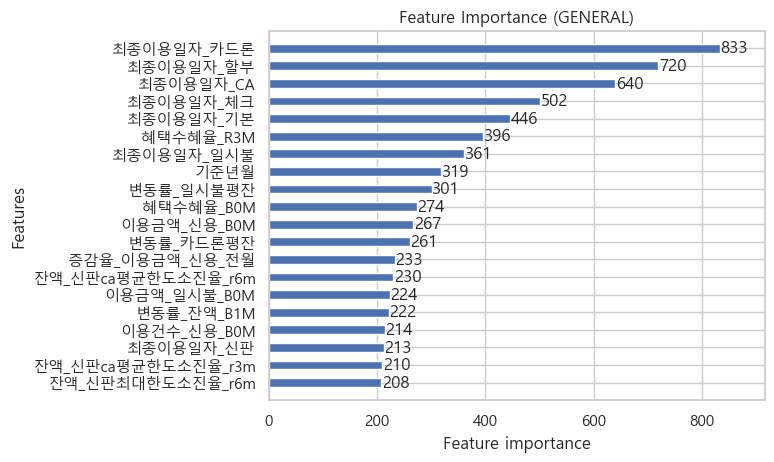

In [30]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# =============================================================================
# [Step 7] LightGBM 모델 학습 (General Only)
# =============================================================================

def train_eval_lgbm_general(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Balanced) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 제거 (타겟 유출 방지)
    # Target과 발급회원번호는 학습에 직접 쓰지 않으므로 분리
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        # 아래 변수들은 Feature Importance 단계에서 이미 걸러졌을 수 있으나 안전장치로 포함
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
    ]
    
    # 실제 학습에 사용할 Feature(X)와 Target(y) 분리
    # Target은 반드시 존재해야 함
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None

    y = df_train['Target']
    
    # Leakage 컬럼 제외 및 수치형 데이터만 선택
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    X = df_train.drop(columns=cols_to_drop)
    X = X.select_dtypes(include=['number']) 
    
    print(f" - 학습 Feature 수: {X.shape[1]}개")
    print(f" - 학습 데이터 샘플 수: {X.shape[0]}개")
    
    # 3. Train / Test Split
    # stratify=y를 통해 이탈/비이탈 비율을 유지하며 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 4. LightGBM 파라미터 설정
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced' # [핵심] 불균형 데이터 자동 보정
    }
    
    # GPU 설정 (필요시 활성화)
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # 다중 클래스일 경우 weighted 권장 (2진분류도 호환)
    # AUC는 2진 분류일 때만 계산 (Target 1, 2인 경우 0, 1로 매핑 필요할 수 있음)
    try:
        # Target이 1, 2로 되어있다면 2를 0으로 인식하게 하거나 pos_label 지정 필요
        # 여기서는 모델이 알아서 클래스를 인식하므로 그대로 진행 시도
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0 # 에러 시 0 처리

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

# =============================================================================
# [실행] General 모델 학습
# =============================================================================

# df_final: 앞선 [Step 6]에서 Top 100 Feature로 추출된 데이터프레임
if 'df_final' in locals() and df_final is not None:
    model_gen, res_gen = train_eval_lgbm_general(
        input_data=df_final, 
        group_name='GENERAL', 
        device_type='cpu' # GPU 사용 시 'gpu'로 변경
    )
else:
    print("⛔ 'df_final' 데이터가 준비되지 않았습니다. 앞선 코드를 먼저 실행해주세요.")

## 모델 파라미터 수정

📊 [Feature Importance Top 10]
      Feature  Importance
0  최종이용일자_카드론         833
1   최종이용일자_할부         720
2   최종이용일자_CA         640
3   최종이용일자_체크         502
4   최종이용일자_기본         446
5   혜택수혜율_R3M         396
6  최종이용일자_일시불         361
7        기준년월         319
8   변동률_일시불평잔         301
9   혜택수혜율_B0M         274
----------------------------------------
🚨 [Leakage 진단]
   - 1위 변수: 최종이용일자_카드론 (833)
   - 2위 변수: 최종이용일자_할부 (720)
   - 격차 비율: 1.16배
   ✅ 양호: 특정 변수의 독점 현상은 보이지 않습니다.


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2147272484.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(20), x='Importance', y='Feature', palette='viridis')


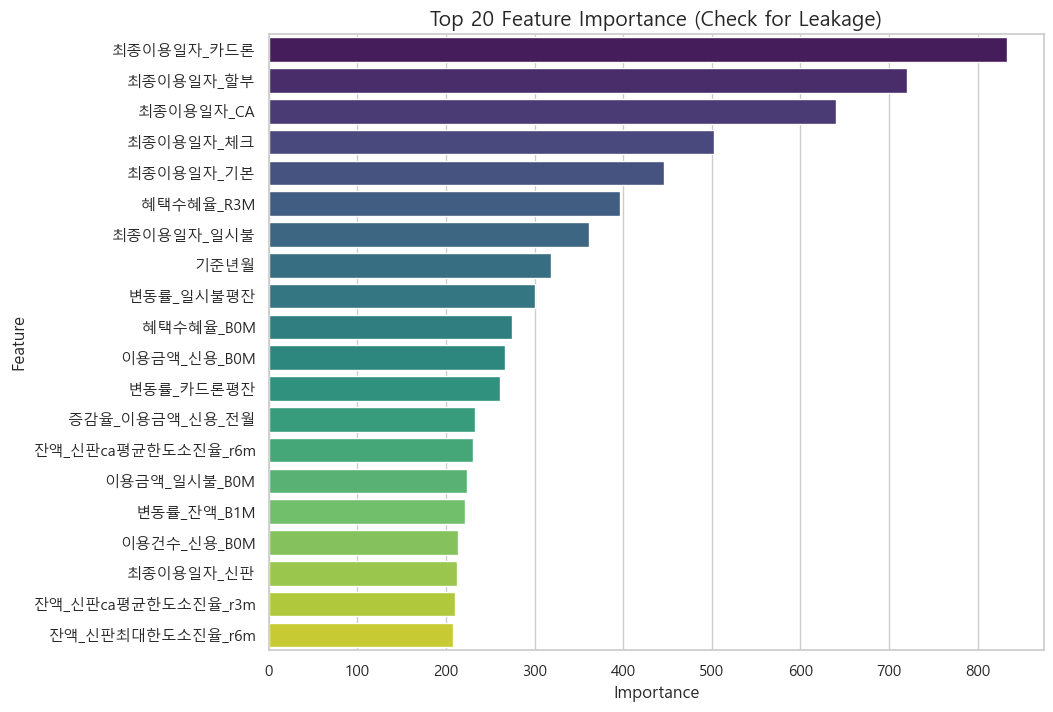

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# [검증] Feature Importance 정밀 분석 (Leakage 탐지용)
# =============================================================================

def check_feature_leakage(model, feature_names):
    # 1. 중요도 추출 (Split 기준: 변수가 모델 분기에 사용된 횟수)
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    })
    
    # 2. 내림차순 정렬
    imp_df = imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # 3. [핵심] 1위와 2위의 격차 계산
    top1_score = imp_df.loc[0, 'Importance']
    top2_score = imp_df.loc[1, 'Importance']
    ratio = top1_score / top2_score if top2_score > 0 else 0
    
    print(f"📊 [Feature Importance Top 10]")
    print(imp_df.head(10))
    print("-" * 40)
    print(f"🚨 [Leakage 진단]")
    print(f"   - 1위 변수: {imp_df.loc[0, 'Feature']} ({top1_score})")
    print(f"   - 2위 변수: {imp_df.loc[1, 'Feature']} ({top2_score})")
    print(f"   - 격차 비율: {ratio:.2f}배")
    
    if ratio >= 2.0:
        print("   ⚠️ 경고: 1위 변수의 영향력이 2위보다 2배 이상 큽니다. Leakage 가능성을 의심해 보세요.")
    else:
        print("   ✅ 양호: 특정 변수의 독점 현상은 보이지 않습니다.")
        
    # 4. 시각화
    plt.figure(figsize=(10, 8))
    sns.barplot(data=imp_df.head(20), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 20 Feature Importance (Check for Leakage)', fontsize=15)
    plt.show()
    
    return imp_df

# 실행 (model_gen이 메모리에 있어야 함)
if 'model_gen' in locals():
    # 모델에서 사용된 Feature 이름 가져오기
    feature_names = model_gen.feature_name_
    df_importance_check = check_feature_leakage(model_gen, feature_names)
else:
    print("⛔ 'model_gen' 모델이 정의되지 않았습니다. 앞선 모델 학습 코드를 먼저 실행해주세요.")

#### 모델 재학습 - 최종 이용 일자 관련 컬럼 제거


==================== [GENERAL] Re-Training (Leakage Removed) ====================
 - 제거된 Leakage 변수: 20개
 - 최종 학습 Feature 수: 82개
✅ 재학습 완료 (소요시간: 4.23초)

📊 [GENERAL] New Model Performance
 - Accuracy  : 0.8325
 - F1 Score  : 0.8724
 - ROC-AUC   : 0.9226
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     45277
           1       0.25      0.89      0.39      2851

    accuracy                           0.83     48128
   macro avg       0.62      0.86      0.64     48128
weighted avg       0.95      0.83      0.87     48128



<Figure size 1000x800 with 0 Axes>

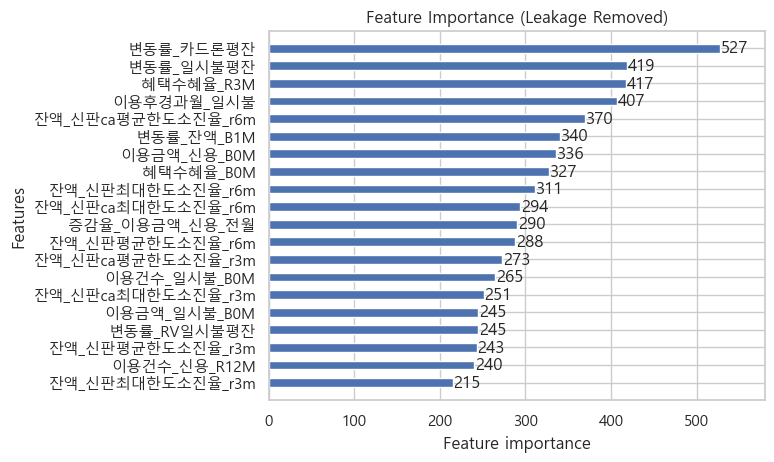

In [32]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# =============================================================================
# [Step 7] LightGBM 모델 재학습 (Leakage 변수 추가 제거)
# =============================================================================

def train_eval_lgbm_general_v2(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Re-Training (Leakage Removed) {'='*20}")
    
    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None, None
        
    df_train = input_data.copy()

    # -------------------------------------------------------------------------
    # [수정] 제거할 변수 목록 업데이트 (최종이용일자, 기준년월 포함)
    # -------------------------------------------------------------------------
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월', # 기준년월도 제거 권장
        
        # [NEW] Leakage로 판명된 날짜 관련 변수 제거
        '최종이용일자_카드론', '최종이용일자_할부', '최종이용일자_CA', 
        '최종이용일자_체크', '최종이용일자_기본', '최종이용일자_일시불',
        '최종이용일자_신판', # 혹시 있다면 같이 제거
        
        # 기존 제외 변수들
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
    ]
    
    # 실제 존재하는 컬럼만 골라서 제거
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    # -------------------------------------------------------------------------
    
    y = df_train['Target']
    X = df_train.drop(columns=cols_to_drop)
    X = X.select_dtypes(include=['number']) 
    
    print(f" - 제거된 Leakage 변수: {len(cols_to_drop)}개")
    print(f" - 최종 학습 Feature 수: {X.shape[1]}개")
    
    # Train / Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced' 
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 학습
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start_time
    print(f"✅ 재학습 완료 (소요시간: {elapsed:.2f}초)")

    # 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] New Model Performance")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Feature Importance 재확인
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance (Leakage Removed)')
    plt.show()

    return model, (acc, f1, auc)

# 실행
if 'df_final' in locals() and df_final is not None:
    model_gen_v2, res_gen_v2 = train_eval_lgbm_general_v2(
        input_data=df_final, 
        group_name='GENERAL', 
        device_type='cpu'
    )

#### Optuna 를 활용한 최적의 파라미터 찾기

c:\Users\johnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-31 13:23:58,593] A new study created in memory with name: no-name-4f52fa99-5b87-4d5b-94ef-e475cf708f10


==================== [Optuna] Hyperparameter Tuning Start ====================
 - 목표: F1 Score (Class 1) 최대화
 - 탐색 횟수: 20회 (시간 관계상 20회로 설정, 필요시 n_trials 증가 가능)


[I 2025-12-31 13:24:03,580] Trial 0 finished with value: 0.412712233347845 and parameters: {'n_estimators': 350, 'learning_rate': 0.09556428757689246, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 32, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946, 'scale_pos_weight': 13.126466040849092}. Best is trial 0 with value: 0.412712233347845.
[I 2025-12-31 13:24:08,227] Trial 1 finished with value: 0.4469975127324411 and parameters: {'n_estimators': 441, 'learning_rate': 0.0737265320016441, 'num_leaves': 20, 'max_depth': 15, 'min_child_samples': 87, 'reg_alpha': 2.1233911067827616, 'reg_lambda': 1.8182496720710062, 'scale_pos_weight': 3.5676631379480734}. Best is trial 1 with value: 0.4469975127324411.
[I 2025-12-31 13:24:20,241] Trial 2 finished with value: 0.4404202101050525 and parameters: {'n_estimators': 322, 'learning_rate': 0.05722807884690141, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 69, 'reg_alpha': 1.3949386065204183, 'reg_lambda': 2.9214464


✅ 최적화 완료!
 - Best F1 Score: 0.4489
 - Best Params: {'n_estimators': 481, 'learning_rate': 0.07044153842586906, 'num_leaves': 53, 'max_depth': 12, 'min_child_samples': 61, 'reg_alpha': 2.77977230544977, 'reg_lambda': 1.269848440010871, 'scale_pos_weight': 5.778309768000859}

==================== [Optuna Best Model] Final Training ====================

📊 [Final Optimized Model] Performance Report
 - Accuracy  : 0.8945
 - F1 Score  : 0.9125
 - ROC-AUC   : 0.9257
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     45277
           1       0.33      0.73      0.45      2851

    accuracy                           0.89     48128
   macro avg       0.65      0.82      0.70     48128
weighted avg       0.94      0.89      0.91     48128



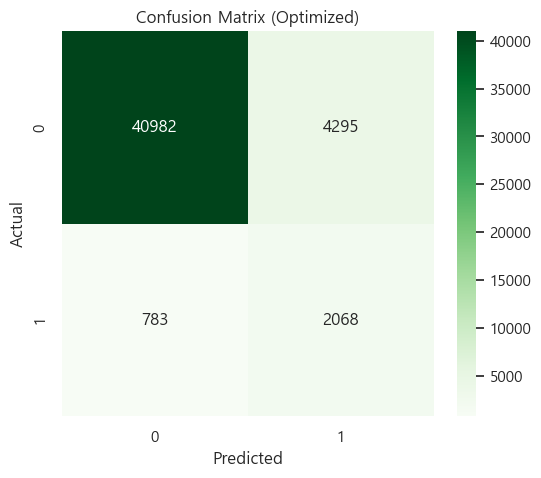

<Figure size 1000x800 with 0 Axes>

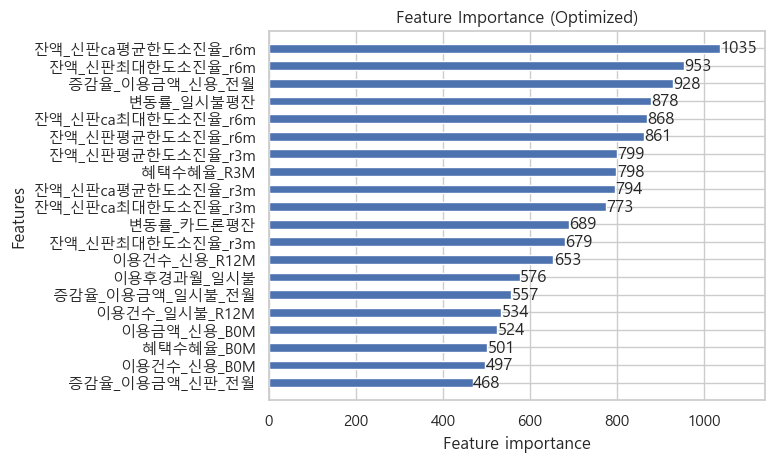

In [33]:
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# =============================================================================
# [Step 8] Optuna를 활용한 하이퍼파라미터 최적화 (Auto-Tuning)
# =============================================================================

def objective(trial):
    # 1. 데이터 준비 (Leakage 제거된 df_final 사용)
    # (Global 변수 df_final을 참조합니다)
    data = df_final.copy()
    
    # Leakage 컬럼 제거 (앞선 Step 7과 동일하게 적용)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        '최종이용일자_카드론', '최종이용일자_할부', '최종이용일자_CA', 
        '최종이용일자_체크', '최종이용일자_기본', '최종이용일자_일시불', '최종이용일자_신판',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
    ]
    cols_to_drop = [c for c in leakage_cols if c in data.columns]
    
    X = data.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y = data['Target']
    
    # Train / Valid Split (검증용 데이터 분리)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 2. 튜닝할 파라미터 탐색 범위 설정 (Search Space)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        
        # [핵심] class_weight 비율 조절 (1 ~ 15)
        # 1에 가까울수록 일반 학습, 15에 가까울수록 balanced와 유사
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 15.0),
        
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'cpu' # GPU 사용시 'gpu'로 변경
    }
    
    # 3. 모델 학습
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    # 4. 평가 지표 (F1 Score Maximization)
    # Precision과 Recall의 조화평균인 F1 Score를 최대화하는 방향으로 최적화
    y_pred = model.predict(X_valid)
    
    # Target이 1인 클래스(이탈자)에 대한 F1 Score 반환
    # (average='binary'는 Target 0, 1 중 1을 Positive로 간주)
    score = f1_score(y_valid, y_pred, pos_label=1)
    
    return score

# -----------------------------------------------------------------------------
# [실행] 최적화 프로세스 시작
# -----------------------------------------------------------------------------
print(f"{'='*20} [Optuna] Hyperparameter Tuning Start {'='*20}")
print(" - 목표: F1 Score (Class 1) 최대화")
print(" - 탐색 횟수: 20회 (시간 관계상 20회로 설정, 필요시 n_trials 증가 가능)")

# Study 생성 및 최적화 수행
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20) # 20번 시도

# 결과 출력
print(f"\n✅ 최적화 완료!")
print(f" - Best F1 Score: {study.best_value:.4f}")
print(f" - Best Params: {study.best_params}")

# -----------------------------------------------------------------------------
# [최종] Best Parameter로 모델 재학습 및 상세 리포트
# -----------------------------------------------------------------------------
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['verbose'] = -1

print(f"\n{'='*20} [Optuna Best Model] Final Training {'='*20}")

# 데이터 준비 (재학습용)
data = df_final.copy()
leakage_cols = [
    'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
    '최종이용일자_카드론', '최종이용일자_할부', '최종이용일자_CA', 
    '최종이용일자_체크', '최종이용일자_기본', '최종이용일자_일시불', '최종이용일자_신판',
    'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
    'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
    'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
    'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
    'Risk_Count', 'Churn_Segment',
    'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
]
cols_to_drop = [c for c in leakage_cols if c in data.columns]
X = data.drop(columns=cols_to_drop).select_dtypes(include=['number'])
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 최적 파라미터로 모델 생성
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# 최종 평가
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print(f"\n📊 [Final Optimized Model] Performance Report")
print(f" - Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
print(f" - F1 Score  : {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f" - ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")
print("-" * 50)
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Optimized)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(final_model, max_num_features=20, height=0.5, title='Feature Importance (Optimized)')
plt.show()

#### Threshold(임계값) 찾기


📊 [Threshold Optimization Report]
 - 기본 설정 (0.50) F1 Score : 0.4489
 - 최적 설정 (0.5026) F1 Score : 0.4494 (▲ Improvement)


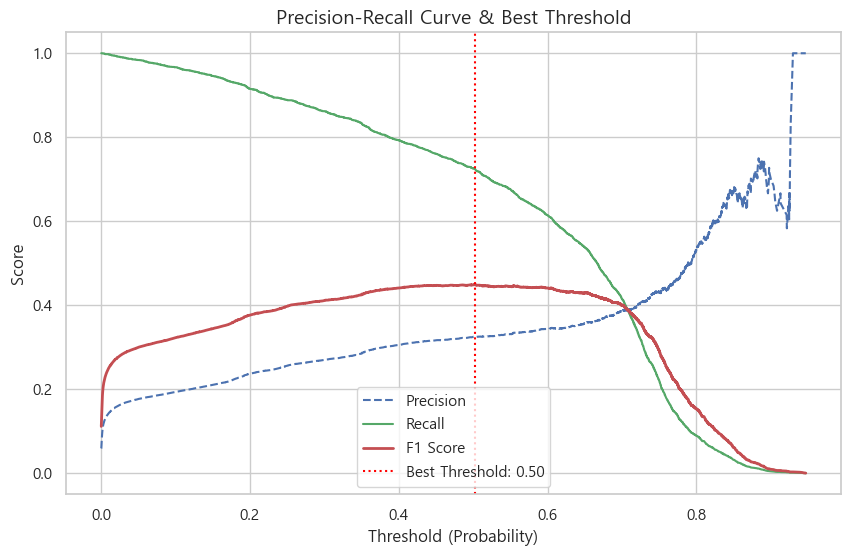


[0.5026 임계값 적용 시 성능]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     45277
           1       0.33      0.72      0.45      2851

    accuracy                           0.89     48128
   macro avg       0.65      0.82      0.70     48128
weighted avg       0.94      0.89      0.91     48128



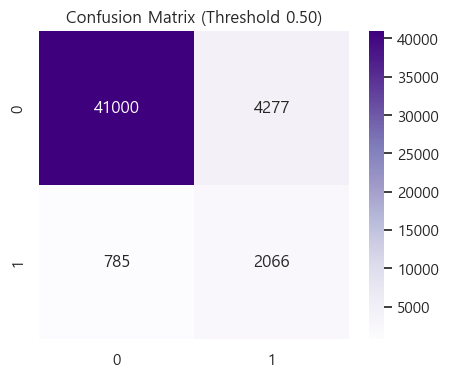

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix

# =============================================================================
# [Step 9] 최적의 결정 임계값(Threshold) 탐색
# =============================================================================

def find_optimal_threshold(model, X_test, y_test):
    # 1. 이탈 확률 예측 (Probability)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 2. Precision-Recall Curve 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
    
    # 3. F1 Score 계산 (모든 임계값에 대해)
    # F1 = 2 * (Precision * Recall) / (Precision + Recall)
    # 분모가 0이 되는 경우를 대비해 안전장치 추가
    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # 4. 최대 F1 Score를 가지는 인덱스 찾기
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"\n📊 [Threshold Optimization Report]")
    print(f" - 기본 설정 (0.50) F1 Score : {f1_score(y_test, (y_prob >= 0.5).astype(int)):.4f}")
    print(f" - 최적 설정 ({best_threshold:.4f}) F1 Score : {best_f1:.4f} (▲ Improvement)")
    
    # 5. 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score', linewidth=2)
    
    plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold: {best_threshold:.2f}')
    plt.title('Precision-Recall Curve & Best Threshold', fontsize=14)
    plt.xlabel('Threshold (Probability)')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    return best_threshold

# [실행]
# final_model과 테스트 데이터가 메모리에 있어야 합니다.
if 'final_model' in locals():
    best_th = find_optimal_threshold(final_model, X_test, y_test)
    
    # [검증] 최적 임계값 적용 결과 확인
    print(f"\n[{best_th:.4f} 임계값 적용 시 성능]")
    y_pred_new = (final_model.predict_proba(X_test)[:, 1] >= best_th).astype(int)
    
    print(classification_report(y_test, y_pred_new))
    
    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_new), annot=True, fmt='d', cmap='Purples')
    plt.title(f'Confusion Matrix (Threshold {best_th:.2f})')
    plt.show()
else:
    print("⛔ 'final_model'이 정의되지 않았습니다. 앞선 Optuna 코드를 먼저 실행해주세요.")

# 변수중요도확인 -> Shap/Vif

In [39]:
# !pip install statsmodels

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 한글 폰트 설정 (Mac: 'AppleGothic', Windows: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# [Step 1.5] VIF(다중공선성) 확인 (모델 학습 전 권장)
# =============================================================================
print("🔍 VIF(분산 팽창 지수) 계산 중... (변수 간 상관관계 확인)")

# VIF 계산 함수 정의
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    
    # 데이터가 너무 많으면 VIF 계산이 느리므로, 
    # 랜덤으로 5,000개만 샘플링해서 계산하는 것이 효율적입니다.
    if len(dataframe) > 5000:
        df_sample = dataframe.sample(n=5000, random_state=42)
    else:
        df_sample = dataframe
        
    vif_data["VIF"] = [variance_inflation_factor(df_sample.values, i) 
                       for i in range(df_sample.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

# X_reduced는 이전 단계에서 VarianceThreshold를 통과한 데이터라고 가정합니다.
vif_df = calculate_vif(df_final)

print("\n📊 상위 10개 VIF 변수 (10 이상이면 다중공선성 의심):")
print(vif_df.head(10))

# (선택사항) VIF가 10 이상인 변수를 제거하고 싶다면 아래 주석을 해제하여 적용
# high_vif_cols = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
# X_final = X_reduced.drop(columns=high_vif_cols)
# print(f" - VIF 높은 변수 {len(high_vif_cols)}개 제거 완료")
X_final = X_reduced # 일단 제거 없이 진행

# =============================================================================
# [Step 2] XGBoost 모델 학습
# =============================================================================
print("\n🚀 XGBoost 모델 학습 중...")

# XGBoost 분류기 설정
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # 나무의 개수
    learning_rate=0.1,      # 학습률
    max_depth=5,            # 나무의 깊이 (너무 깊으면 과적합 위험)
    random_state=42,
    n_jobs=-1,              # CPU 병렬 처리
    enable_categorical=False # 수치형 데이터만 사용하므로 False
)

xgb_model.fit(X_final, y)
print(" - 학습 완료!")

# =============================================================================
# [Step 3] SHAP Value 추출 및 시각화
# =============================================================================
print("\n✨ SHAP Value 계산 중... (시간이 조금 걸릴 수 있습니다)")

# TreeExplainer 객체 생성 (트리 기반 모델에 최적화된 설명 도구)
explainer = shap.TreeExplainer(xgb_model)

# SHAP 값 계산 (전체 데이터가 크면 일부만 샘플링해서 시각화 추천)
# 속도를 위해 1,000~2,000개 샘플만 사용해 전체 경향을 파악합니다.
if len(X_final) > 2000:
    X_shap = X_final.sample(n=2000, random_state=42)
else:
    X_shap = X_final

shap_values = explainer.shap_values(X_shap)

# 1. SHAP Summary Plot (가장 많이 쓰이는 그래프)
# - 변수의 영향력과 방향(빨간색: 높음 -> 이탈 영향, 파란색: 낮음 -> 이탈 영향 등)을 보여줌
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (XGBoost)", fontsize=15, fontweight='bold')
plt.tight_layout()
# plt.savefig('SHAP_Summary_Plot.png', dpi=300)
plt.show()

# 2. SHAP Bar Plot (변수 중요도 순위)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ 분석 및 시각화 완료.")

🔍 VIF(분산 팽창 지수) 계산 중... (변수 간 상관관계 확인)


TypeError: '>=' not supported between instances of 'str' and 'float'

# 수정된 타겟 형성 및 적용
- 기울기 점수 부여 변동
    - 8~12 누적 기울기 적용
    - 7 -> 컬럼 중 12개월 데이터 활용해서 평균과 비교

## 데이터 분포 확인 - 상태기반 점수 수정 - 건수

In [40]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_COUNT_SPEND = '이용건수_신판_B0M' # 빈도 소비 (할부, 일시불)
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT_SPEND].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT_SPEND].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    cond3 = scores['Score_Activity'] < 0
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond3) + int(cond4)
    cond_high_risk = (risk_count >= 1)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")

    return df_res,df

In [ ]:
TEST_FILE = '../../../260108/general_combined_part1.csv'
analyze_rolling_churn(TEST_FILE)


[Info] 파일 로드 및 분석 시작: ../../../260108/general_combined_part1.csv


### 이탈자 데이터 추출

## 모델 학습 - 변경된 타겟 - 상태점수 컬럼 수정


[Info] 파일 로드 및 전처리 시작: ../../../260108/general_combined_part1.csv
 - Target 산출 (R12M 보완 로직)...


C:\Users\johnh\AppData\Local\Temp\ipykernel_8072\1605910072.py:80: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
C:\Users\johnh\AppData\Local\Temp\ipykernel_8072\1605910072.py:346: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


 - Target 생성 완료. 비율: {0: 0.6018214285714286, 1: 0.39817857142857144}
 - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...

==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
✅ 학습 완료 (소요시간: 10.26초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7833
 - F1 Score  : 0.7849
 - ROC-AUC   : 0.8682
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.78      0.81     10111
           1       0.71      0.78      0.74      6689

    accuracy                           0.78     16800
   macro avg       0.78      0.78      0.78     16800
weighted avg       0.79      0.78      0.78     16800



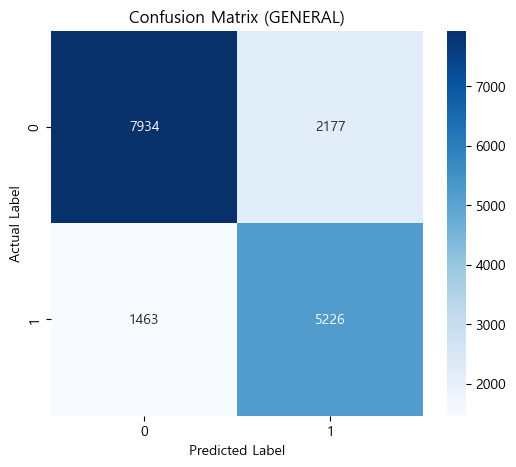

<Figure size 1000x800 with 0 Axes>

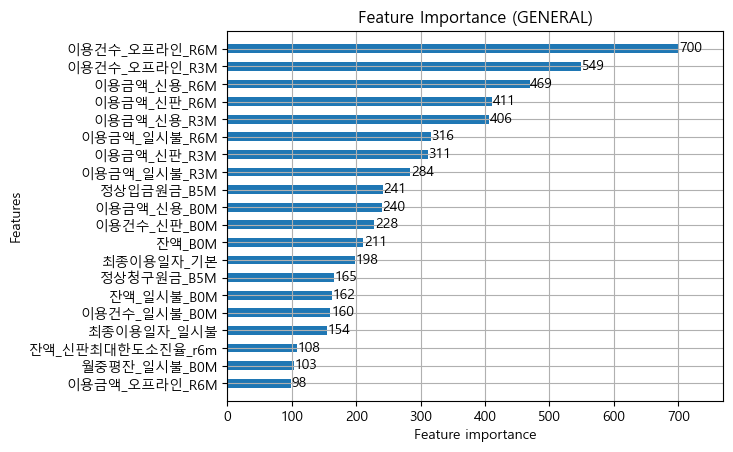

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도(카드론, 현금서비스 포함)
COL_COUNT_SPEND = '이용건수_신판_B0M' # 소비건수 (할부+일시불)
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT_SPEND].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT_SPEND].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def process_data(file_path):
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. 데이터 로드
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

    # 2. 컬럼 확인
    required_cols = [
        COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_COUNT_SPEND, COL_BALANCE, 
        COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
        COL_SPEND_R12M, COL_COUNT_R12M
    ]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        print(f"⚠️ 일부 컬럼 누락 (0으로 대체): {missing_cols}")
        for c in missing_cols:
            df[c] = 0

    # 3. 데이터 정렬
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    print(" - 고객별 지표(Slopes, Scores) 산출 중... (R12M 보완 로직 적용됨)")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # 4. Target 생성 로직 적용
    print(" - Target 생성 중...")
    
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 1개 이상 감지
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    # Target 할당
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - 완료: {len(df_scores)}명 데이터 생성됨.")
    print(f" - Target 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    return df_scores

def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed (probably too few samples of one class). Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    # Drop leakage columns carefully (ignore if not present)
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced'
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

        # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

def process_data_and_merge(file_path):
    # This function needs to return a DF that has both FEATURES (raw) and TARGET.
    
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. Load
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None
    
    # Check R12M cols presence for scoring
    # (If missing, default to 0 for calculations)
    if COL_SPEND_R12M not in df.columns: df[COL_SPEND_R12M] = 0
    if COL_COUNT_R12M not in df.columns: df[COL_COUNT_R12M] = 0

    # 2. Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # 3. Calculate Scores (Target Logic)
    print(" - Target 산출 (R12M 보완 로직)...")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # Generate Target
    # (조건 A)
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    # (조건 B)
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - Target 생성 완료. 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    # 4. Prepare Training Data
    # Option: Use the Last Row of each user as features
    print(" - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...")
    df_last = df.groupby(COL_ID).tail(1).copy()
    
    # Merge Target
    df_final = df_last.merge(df_scores[[COL_ID, 'Target']], on=COL_ID, how='left')
    
    return df_final


[Info] 파일 로드 및 전처리 시작: ../../../260108/general_combined_part1.csv
 - Target 산출 (R12M 보완 로직)...


C:\Users\johnh\AppData\Local\Temp\ipykernel_8072\2882551176.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
C:\Users\johnh\AppData\Local\Temp\ipykernel_8072\1605910072.py:346: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


 - Target 생성 완료. 비율: {0: 0.6018214285714286, 1: 0.39817857142857144}
 - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...

==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 1.51
 - [Info] 적용된 scale_pos_weight: 1.81
✅ 학습 완료 (소요시간: 10.66초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7729
 - F1 Score  : 0.7752
 - ROC-AUC   : 0.8685
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     10111
           1       0.68      0.82      0.74      6689

    accuracy                           0.77     16800
   macro avg       0.77      0.78      0.77     16800
weighted avg       0.79      0.77      0.78     16800



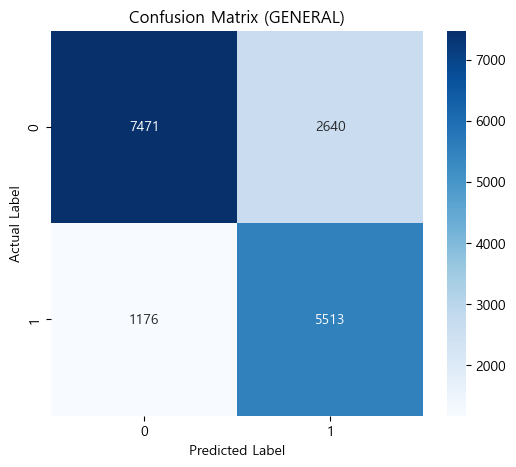

<Figure size 1000x800 with 0 Axes>

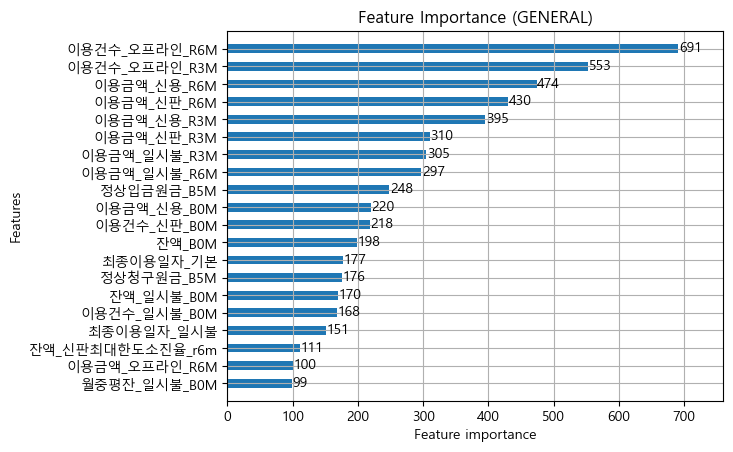

In [29]:

# 파일 경로 (수정 필요)
TRAIN_FILE = '../../../260108/general_combined_part1.csv' # Example file

# 1. Process Data
df_train_final = process_data_and_merge(TRAIN_FILE)

# 2. Train Model
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)


In [35]:
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84000 entries, 0 to 83999
Columns: 847 entries, 발급회원번호 to Target
dtypes: float64(62), int32(1), int64(755), object(29)
memory usage: 542.5+ MB


In [37]:
churn_df = df_train_final[df_train_final['Target'] == 1]

In [ ]:
# churn_df.to_csv('general_churn_전체.csv', index=False)

#### scale_pos_weight 조정

In [18]:
def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed. Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [수정] scale_pos_weight 자동 계산 로직 추가
    # =========================================================
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    
    # 기본 비율 계산 (Negative 수 / Positive 수)
    # 0으로 나누는 것을 방지하기 위한 안전장치 추가
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    
    # 튜닝 포인트: 이탈자를 더 강력하게 잡고 싶다면 ratio * 1.5, ratio * 2.0 등으로 높이세요.
    final_scale_pos_weight = ratio * 1.2 
    
    print(f" - [Info] 자동 계산된 Class Ratio (Neg/Pos): {ratio:.2f}")
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")
    # =========================================================

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        # 'class_weight': 'balanced',    <-- [삭제] 이것 대신 아래 scale_pos_weight 사용
        'scale_pos_weight': final_scale_pos_weight  # <-- [추가]
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

### class_weight 가중치 balance 에서 직접 부여
- 1.2


[Info] 파일 로드 및 전처리 시작: ../../../260108/general_combined_part1.csv
 - Target 산출 (R12M 보완 로직)...


C:\Users\johnh\AppData\Local\Temp\ipykernel_8072\1605910072.py:80: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
C:\Users\johnh\AppData\Local\Temp\ipykernel_8072\1605910072.py:346: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


 - Target 생성 완료. 비율: {0: 0.6018214285714286, 1: 0.39817857142857144}
 - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...

==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 1.51
 - [Info] 적용된 scale_pos_weight: 1.81
✅ 학습 완료 (소요시간: 15.28초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7729
 - F1 Score  : 0.7752
 - ROC-AUC   : 0.8685
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     10111
           1       0.68      0.82      0.74      6689

    accuracy                           0.77     16800
   macro avg       0.77      0.78      0.77     16800
weighted avg       0.79      0.77      0.78     16800



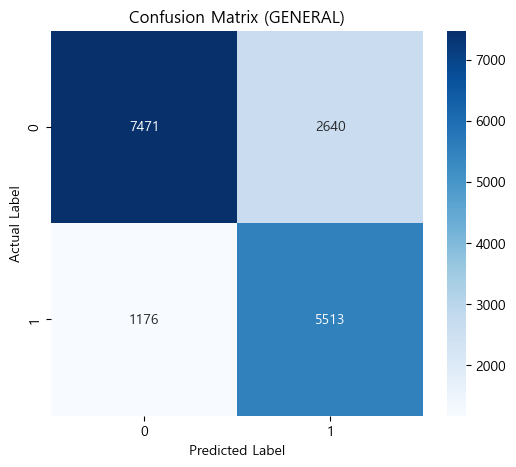

<Figure size 1000x800 with 0 Axes>

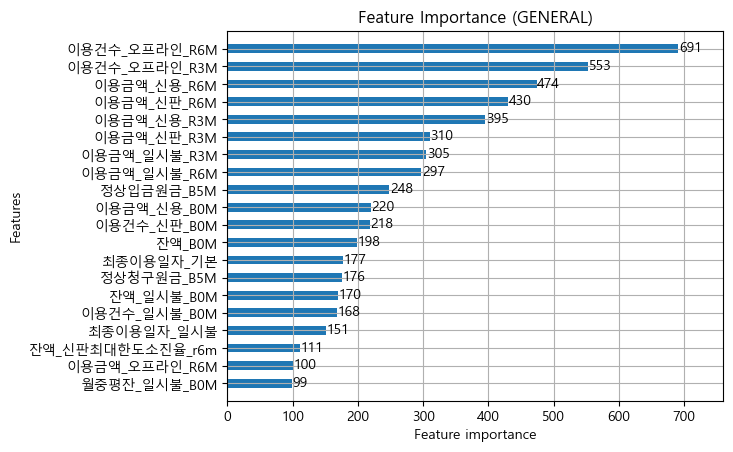

In [19]:
# TRAIN_FILE = 'general_combined_part1.csv' # Example file

# 1. Process Data
df_train_final = process_data_and_merge(TRAIN_FILE)

# 2. Train Model
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)

#### 1.5

In [5]:
def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed. Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [수정] scale_pos_weight 자동 계산 로직 추가
    # =========================================================
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    
    # 기본 비율 계산 (Negative 수 / Positive 수)
    # 0으로 나누는 것을 방지하기 위한 안전장치 추가
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    
    # 튜닝 포인트: 이탈자를 더 강력하게 잡고 싶다면 ratio * 1.5, ratio * 2.0 등으로 높이세요.
    final_scale_pos_weight = ratio * 1.5 
    
    print(f" - [Info] 자동 계산된 Class Ratio (Neg/Pos): {ratio:.2f}")
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")
    # =========================================================

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        # 'class_weight': 'balanced',    <-- [삭제] 이것 대신 아래 scale_pos_weight 사용
        'scale_pos_weight': final_scale_pos_weight  # <-- [추가]
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)


==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 1.51
 - [Info] 적용된 scale_pos_weight: 2.27
✅ 학습 완료 (소요시간: 11.08초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7660
 - F1 Score  : 0.7681
 - ROC-AUC   : 0.8749
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     10109
           1       0.65      0.88      0.75      6691

    accuracy                           0.77     16800
   macro avg       0.77      0.78      0.76     16800
weighted avg       0.80      0.77      0.77     16800



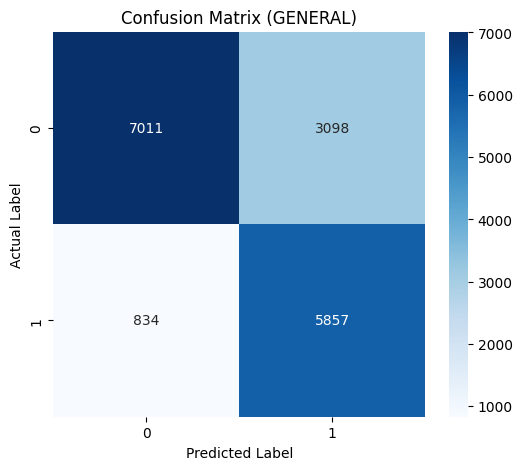

<Figure size 1000x800 with 0 Axes>

C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 525

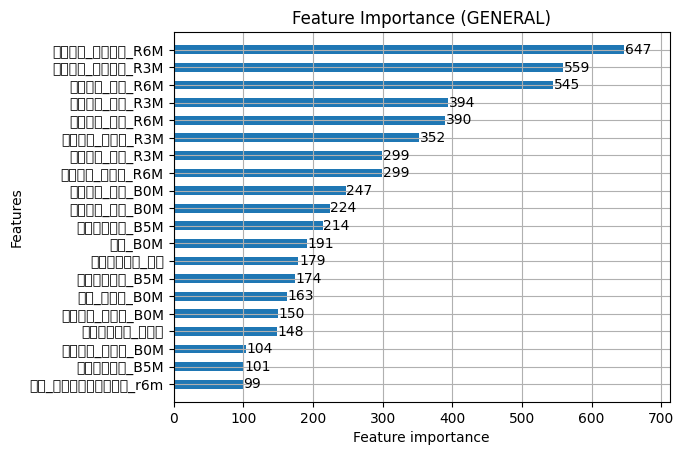

In [6]:
# TRAIN_FILE = 'general_combined_part1.csv' # Example file

# 1. Process Data
# df_train_final = process_data_and_merge(TRAIN_FILE)

# 2. Train Model
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)

## 이탈자 status score 2 이상
- 모델형성

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도(현금서비스, 카드론 포함)
COL_COUNT_SPEND = '이용건수_신판_B0M' # 소비건수(일시불+할부)
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT_SPEND].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT_SPEND].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def process_data(file_path):
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. 데이터 로드
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

    # 2. 컬럼 확인
    required_cols = [
        COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_COUNT_SPEND, COL_BALANCE, 
        COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
        COL_SPEND_R12M, COL_COUNT_R12M
    ]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        print(f"⚠️ 일부 컬럼 누락 (0으로 대체): {missing_cols}")
        for c in missing_cols:
            df[c] = 0

    # 3. 데이터 정렬
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    print(" - 고객별 지표(Slopes, Scores) 산출 중... (R12M 보완 로직 적용됨)")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # 4. Target 생성 로직 적용
    print(" - Target 생성 중...")
    
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 1개 이상 감지
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 2)
    
    # Target 할당
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - 완료: {len(df_scores)}명 데이터 생성됨.")
    print(f" - Target 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    return df_scores

def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed (probably too few samples of one class). Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    # Drop leakage columns carefully (ignore if not present)
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced'
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

        # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

def process_data_and_merge(file_path):
    # This function needs to return a DF that has both FEATURES (raw) and TARGET.
    
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. Load
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None
    
    # Check R12M cols presence for scoring
    # (If missing, default to 0 for calculations)
    if COL_SPEND_R12M not in df.columns: df[COL_SPEND_R12M] = 0
    if COL_COUNT_R12M not in df.columns: df[COL_COUNT_R12M] = 0

    # 2. Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # 3. Calculate Scores (Target Logic)
    print(" - Target 산출 (R12M 보완 로직)...")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # Generate Target
    # (조건 A)
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    # (조건 B)
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - Target 생성 완료. 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    # 4. Prepare Training Data
    # Option: Use the Last Row of each user as features
    print(" - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...")
    df_last = df.groupby(COL_ID).tail(1).copy()
    
    # Merge Target
    df_final = df_last.merge(df_scores[[COL_ID, 'Target']], on=COL_ID, how='left')
    
    return df_final


==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
✅ 학습 완료 (소요시간: 9.11초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7824
 - F1 Score  : 0.7840
 - ROC-AUC   : 0.8739
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     10109
           1       0.70      0.79      0.74      6691

    accuracy                           0.78     16800
   macro avg       0.77      0.78      0.78     16800
weighted avg       0.79      0.78      0.78     16800



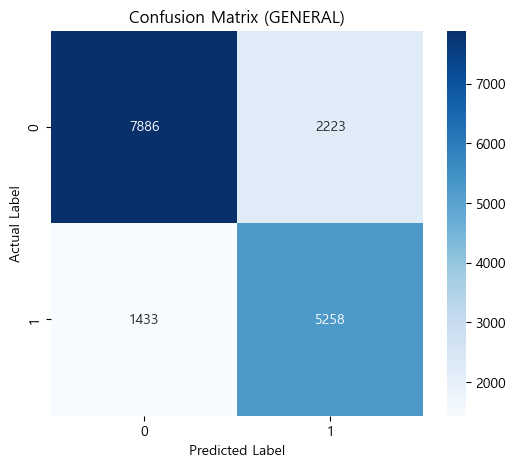

<Figure size 1000x800 with 0 Axes>

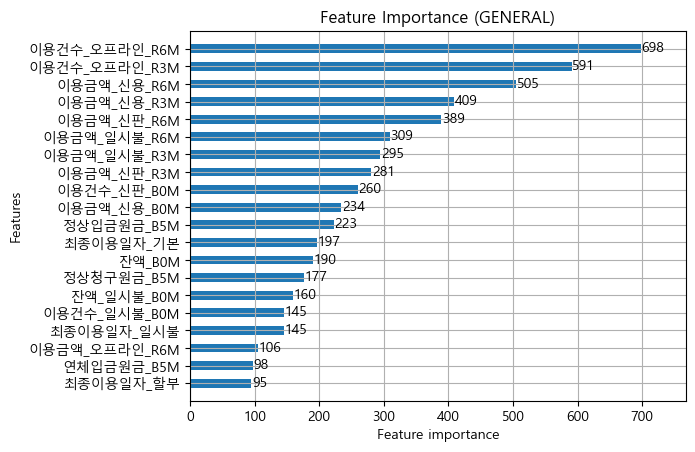

In [15]:

# 1. Process Data
# df_train_final = process_data_and_merge(TRAIN_FILE)

# 2. Train Model
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)


### status score 2 이상으로 설정
- 분포 확인

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    cond3 = scores['Score_Activity'] < 0
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond3) + int(cond4)
    cond_high_risk = (risk_count >= 2)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")



In [13]:

analyze_rolling_churn(TEST_FILE)


[Info] 파일 로드 및 분석 시작: ../../../260108/general_combined_part1.csv
 - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)


C:\Users\johnh\AppData\Local\Temp\ipykernel_8072\2375762321.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100



📊 이탈자 Rolling 분석 결과 (대상 파일: general_combined_part1.csv)
 - 총 분석 고객 수: 84000명
 - 최종 시점 이탈자 수: 5178명 (6.16%)
------------------------------
 [이탈 징후 지속 기간 통계]
count    5178.000000
mean        1.661452
std         0.740339
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Churn_Duration_Months, dtype: float64
------------------------------
 [기간별 분포 (상위 10개)]
Churn_Duration_Months
5       1
4       1
3     830
2    1758
1    2588
Name: count, dtype: int64

✅ 상세 결과 저장 완료: churn_duration_results_general_combined_part1.csv


## 상태기반점수에서 활동성 점수 제거

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    # cond3 = scores['Score_Activity'] < 0  # 활동성 감소 논리적으로 기울기 부분이랑 겹침
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond4)  # + int(cond3)
    cond_high_risk = (risk_count >= 1)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")



In [ ]:
TRAIN_FILE = '../../../260108/general_combined_part1.csv' # Example file
analyze_rolling_churn(TRAIN_FILE)


[Info] 파일 로드 및 분석 시작: ../../../260108/general_combined_part1.csv
 - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)


C:\Users\johnh\AppData\Local\Temp\ipykernel_32492\1300652192.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100


### 모델 학습

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def process_data(file_path):
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. 데이터 로드
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

    # 2. 컬럼 확인
    required_cols = [
        COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
        COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
        COL_SPEND_R12M, COL_COUNT_R12M
    ]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        print(f"⚠️ 일부 컬럼 누락 (0으로 대체): {missing_cols}")
        for c in missing_cols:
            df[c] = 0

    # 3. 데이터 정렬
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    print(" - 고객별 지표(Slopes, Scores) 산출 중... (R12M 보완 로직 적용됨)")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # 4. Target 생성 로직 적용
    print(" - Target 생성 중...")
    
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 1개 이상 감지
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    # cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    
    risk_count = cond1.astype(int) + cond2.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    # Target 할당
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - 완료: {len(df_scores)}명 데이터 생성됨.")
    print(f" - Target 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    return df_scores

def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed (probably too few samples of one class). Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    # Drop leakage columns carefully (ignore if not present)
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced'
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

        # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

def process_data_and_merge(file_path):
    # This function needs to return a DF that has both FEATURES (raw) and TARGET.
    
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. Load
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None
    
    # Check R12M cols presence for scoring
    # (If missing, default to 0 for calculations)
    if COL_SPEND_R12M not in df.columns: df[COL_SPEND_R12M] = 0
    if COL_COUNT_R12M not in df.columns: df[COL_COUNT_R12M] = 0

    # 2. Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # 3. Calculate Scores (Target Logic)
    print(" - Target 산출 (R12M 보완 로직)...")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # Generate Target
    # (조건 A)
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    # (조건 B)
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    # cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    risk_count = cond1.astype(int) + cond2.astype(int) + cond4.astype(int) # + cond3.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - Target 생성 완료. 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    # 4. Prepare Training Data
    # Option: Use the Last Row of each user as features
    print(" - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...")
    df_last = df.groupby(COL_ID).tail(1).copy()
    
    # Merge Target
    df_final = df_last.merge(df_scores[[COL_ID, 'Target']], on=COL_ID, how='left')
    
    return df_final

In [ ]:
def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed. Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [수정] scale_pos_weight 자동 계산 로직 추가
    # =========================================================
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    
    # 기본 비율 계산 (Negative 수 / Positive 수)
    # 0으로 나누는 것을 방지하기 위한 안전장치 추가
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    
    # 튜닝 포인트: 이탈자를 더 강력하게 잡고 싶다면 ratio * 1.5, ratio * 2.0 등으로 높이세요.
    final_scale_pos_weight = ratio * 1.0
    
    print(f" - [Info] 자동 계산된 Class Ratio (Neg/Pos): {ratio:.2f}")
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")
    # =========================================================

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        # 'class_weight': 'balanced',    # <-- [삭제] 이것 대신 아래 scale_pos_weight 사용
        'scale_pos_weight': final_scale_pos_weight  # <-- [추가]
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

In [ ]:
df_train_final = process_data_and_merge(TRAIN_FILE)


[Info] 파일 로드 및 전처리 시작: ../../../260108/general_combined_part1.csv
 - Target 산출 (R12M 보완 로직)...


C:\Users\johnh\AppData\Local\Temp\ipykernel_15488\3134445339.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
C:\Users\johnh\AppData\Local\Temp\ipykernel_15488\1348364298.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


 - Target 생성 완료. 비율: {0: 0.8454880952380952, 1: 0.15451190476190477}
 - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...



==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 803개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 5.47
 - [Info] 적용된 scale_pos_weight: 5.47
✅ 학습 완료 (소요시간: 14.88초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.8761
 - F1 Score  : 0.8875
 - ROC-AUC   : 0.9452
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.87      0.92     14204
           1       0.56      0.93      0.70      2596

    accuracy                           0.88     16800
   macro avg       0.77      0.90      0.81     16800
weighted avg       0.92      0.88      0.89     16800



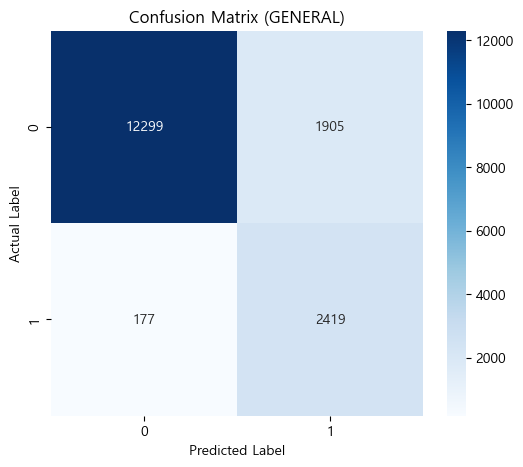

<Figure size 1000x800 with 0 Axes>

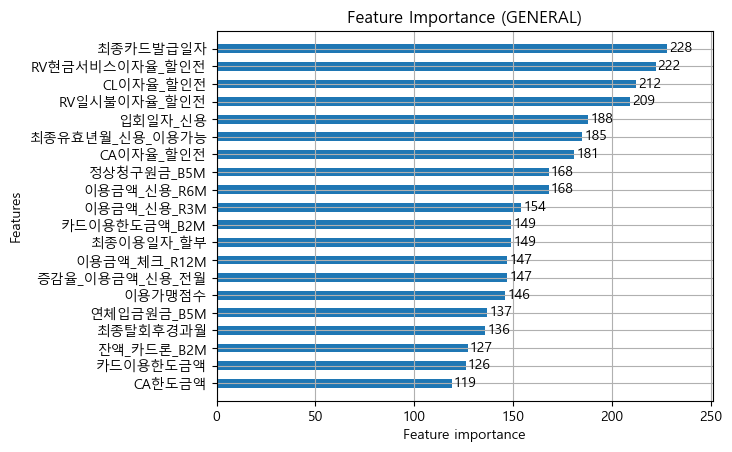

In [ ]:
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)

In [ ]:
'최종이용일자_신판', '이용건수_일시불_B0M',
'최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'

### 데이터 누수 확실하게 제거

In [ ]:
import re
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Ultra-Strict Mode) {'='*20}")
    
    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None, None
    df_train = input_data.copy()

    # =========================================================
    # [Ultra-Strict] 2. Leakage 변수 정의 (행동 데이터 전면 차단)
    # =========================================================
    
    manual_leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '_1순위카드이용건수', '_1순위업종_이용금액', '_1순위카드이용금액'
    ]
    
    auto_leakage_cols = []
    all_cols = df_train.columns
    
    for col in all_cols:
        col_lower = col.lower()
        
        # 1. 시계열/집계 데이터 (BxM, RxM)
        if re.search(r'[br]\d+m', col_lower): 
            auto_leakage_cols.append(col)
            
        # 2. 파생 변수 (비율, 증감, 평균)
        elif any(x in col_lower for x in ['ratio', 'rate', '증감', '대비', 'yoy', 'mom', '비율', '소진율', '평균', '평잔', 'avg']):
            # 단, '이자율(Interest Rate)'은 고객 속성이므로 살려야 함!
            # 'rate'가 들어가지만 'interest'나 '이자'가 있으면 제외(Keep)
            if ('이자' in col or 'interest' in col_lower):
                pass # 살림
            else:
                auto_leakage_cols.append(col)
        
        # 3. [핵심] 금액(Amount) 관련 변수 전면 제거 (단, 한도(Limit)는 살림)
        # 이용금액, 청구금액, 납부금액 등은 모두 행동 데이터임
        elif any(x in col_lower for x in ['금액', 'amt', 'price', 'pay', '납부', '청구', 'bill', '이용']):
            # '한도(Limit)'는 고객 등급 정보이므로 살림
            if ('한도' in col or 'limit' in col_lower):
                pass
            # '가입금액' 등 초기 정보는 살릴 수도 있지만, 안전하게 이용 관련은 다 지움
            else:
                auto_leakage_cols.append(col)

        # 4. [핵심] 건수(Count) 관련 변수 전면 제거
        elif any(x in col_lower for x in ['건수', 'cnt', '횟수', 'count', 'frequency']):
            auto_leakage_cols.append(col)

        # 5. [핵심] 연속성/실적 관련 변수 (최근 패턴 누수 방지)
        elif any(x in col_lower for x in ['연속', '실적', 'coti', 'nout']):
            auto_leakage_cols.append(col)
            
        # 6. 마케팅/컨택/VOC/상태 (역인과성 방지)
        elif any(x in col_lower for x in ['마케팅', '접촉', '컨택', 'contact', 'voc', '민원', '해지', '방어', '상담']):
            auto_leakage_cols.append(col)
            
        # 7. 날짜/경과 (최신성 누수 방지)
        elif any(x in col_lower for x in ['최종', '일자', '경과', 'date', 'day', 'elapsed']):
            # 가입일/발급일(Tenure)은 중요하므로 살림
            if ('가입' in col or '발급' in col or '입회' in col or 'join' in col_lower or 'issue' in col_lower):
                pass
            else:
                auto_leakage_cols.append(col)

    final_leakage_cols = list(set(manual_leakage_cols + auto_leakage_cols))
    
    print(f" - [Leakage 제거] 총 {len(final_leakage_cols)}개 컬럼을 학습에서 제외합니다.")
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None

    # 3. Train / Test Split
    print(" - [Info] Group-based Split 적용")
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=42, stratify=unique_user_target['Target'])
    except:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=42)
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]

    cols_to_drop = [c for c in final_leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # scale_pos_weight 자동 계산
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    final_scale_pos_weight = ratio * 2.0
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")

    params = {
        'n_estimators': 400, 'learning_rate': 0.05, 'num_leaves': 31,
        'max_depth': -1, 'random_state': 42, 'n_jobs': -1,
        'device': device_type, 'verbose': -1,
        'scale_pos_weight': final_scale_pos_weight
        # 'class_weight': 'balanced'
    }
    
    if device_type == 'gpu': params['gpu_platform_id'] = 0; params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    print(f"✅ 학습 완료")

    # 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try: auc = roc_auc_score(y_test, y_prob)
    except: auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.show()

    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()
    
    # Feature Importance 출력
    imp_df = pd.DataFrame({
        'Feature_Name': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print(f"\n🔍 [Feature Importance Detail - Top 30]")
    print(imp_df.head(30).to_string()) 

    return model, (acc, f1, auc)


==================== [GENERAL] Training Start (Ultra-Strict Mode) ====================
 - [Leakage 제거] 총 801개 컬럼을 학습에서 제외합니다.
 - [Info] Group-based Split 적용
 - 최종 학습 Feature 수: 43개
 - [Info] 적용된 scale_pos_weight: 10.94
✅ 학습 완료

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.6051
 - F1 Score  : 0.6588
 - ROC-AUC   : 0.7844
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.56      0.71     14204
           1       0.26      0.82      0.39      2596

    accuracy                           0.61     16800
   macro avg       0.60      0.69      0.55     16800
weighted avg       0.84      0.61      0.66     16800



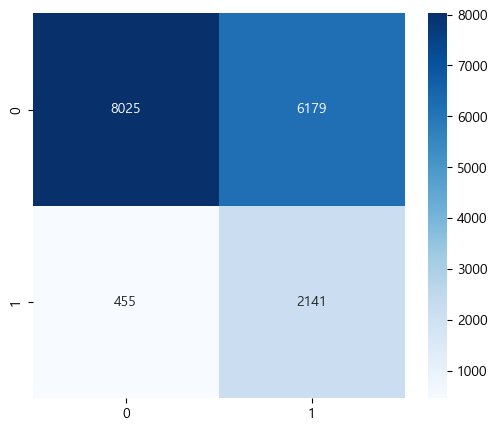

<Figure size 1000x800 with 0 Axes>

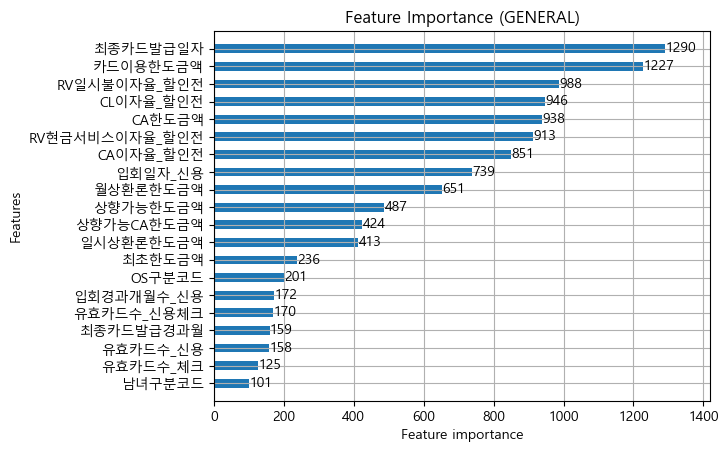


🔍 [Feature Importance Detail - Top 30]
       Feature_Name  Importance
0          최종카드발급일자        1290
1          카드이용한도금액        1227
2      RV일시불이자율_할인전         988
3         CL이자율_할인전         946
4            CA한도금액         938
5    RV현금서비스이자율_할인전         913
6         CA이자율_할인전         851
7           입회일자_신용         739
8          월상환론한도금액         651
9          상향가능한도금액         487
10       상향가능CA한도금액         424
11        일시상환론한도금액         413
12           최초한도금액         236
13           OS구분코드         201
14       입회경과개월수_신용         172
15       유효카드수_신용체크         170
16        최종카드발급경과월         159
17         유효카드수_신용         158
18         유효카드수_체크         125
19           남녀구분코드         101
20          회원여부_연체          93
21    일시불ONLY전환가능여부          83
22      소지카드수_유효_신용          81
23  보유여부_해외겸용_신용_본인          77
24     월상환론상향가능한도금액          74
25       수신거부여부_SMS          68
26      동의여부_한도증액안내          67
27        수신거부여부_TM          66
28     보유여부_해외겸용_본인          55


In [ ]:
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)

In [ ]:
import optuna
import lightgbm as lgb
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def tune_lgbm_with_optuna(input_data, group_name='GENERAL', n_trials=30, random_state=42):
    print(f"\n{'='*20} [{group_name}] Optuna Hyperparameter Tuning Start {'='*20}")
    
    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None, None
    df_train = input_data.copy()

    # =========================================================
    # [Ultra-Strict] Leakage 변수 제거 (검증된 로직 유지)
    # =========================================================
    manual_leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '_1순위카드이용건수', '_1순위업종_이용금액', '_1순위카드이용금액'
    ]
    
    auto_leakage_cols = []
    all_cols = df_train.columns
    
    for col in all_cols:
        col_lower = col.lower()
        # 1. 시계열/집계 (BxM, RxM)
        if re.search(r'[br]\d+m', col_lower): auto_leakage_cols.append(col)
        # 2. 파생 (비율, 증감, 평균) - 이자율 제외
        elif any(x in col_lower for x in ['ratio', 'rate', '증감', '대비', 'yoy', 'mom', '비율', '소진율', '평균', '평잔', 'avg']):
            if not ('이자' in col or 'interest' in col_lower): auto_leakage_cols.append(col)
        # 3. 금액 (Amount) - 한도 제외
        elif any(x in col_lower for x in ['금액', 'amt', 'price', 'pay', '납부', '청구', 'bill', '이용']):
            if not ('한도' in col or 'limit' in col_lower): auto_leakage_cols.append(col)
        # 4. 건수, 횟수
        elif any(x in col_lower for x in ['건수', 'cnt', '횟수', 'count', 'frequency']): auto_leakage_cols.append(col)
        # 5. 연속성/실적
        elif any(x in col_lower for x in ['연속', '실적', 'coti', 'nout']): auto_leakage_cols.append(col)
        # 6. 마케팅/컨택/VOC
        elif any(x in col_lower for x in ['마케팅', '접촉', '컨택', 'contact', 'voc', '민원', '해지', '방어', '상담']): auto_leakage_cols.append(col)
        # 7. 날짜/경과 - 가입일 제외
        elif any(x in col_lower for x in ['최종', '일자', '경과', 'date', 'day', 'elapsed']):
            if not ('가입' in col or '발급' in col or '입회' in col or 'join' in col_lower or 'issue' in col_lower):
                auto_leakage_cols.append(col)

    final_leakage_cols = list(set(manual_leakage_cols + auto_leakage_cols))
    print(f" - [Leakage 제거] 총 {len(final_leakage_cols)}개 컬럼 제외 완료.")

    # Data Split
    if 'Target' not in df_train.columns: return None, None
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    try:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=random_state, stratify=unique_user_target['Target'])
    except:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=random_state)
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    cols_to_drop = [c for c in final_leakage_cols if c in df_train.columns]
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']
    
    print(f" - 학습 Feature 수: {X_train.shape[1]}개")

    # Base Class Ratio Calculation
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    base_ratio = n_neg / n_pos if n_pos > 0 else 1.0

    # =========================================================
    # Optuna Objective Function
    # =========================================================
    def objective(trial):
        # 튜닝할 파라미터 범위 정의
        params = {
            'objective': 'binary',
            'metric': 'auc', # 최적화 기준 (AUC 추천)
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'random_state': random_state,
            'n_jobs': -1,
            
            # [튜닝 대상]
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            
            # [중요] Scale Pos Weight Multiplier (가중치 배수 튜닝)
            # 0.5배(덜 민감) ~ 2.0배(더 민감) 사이에서 조절
            'scale_pos_weight': base_ratio * trial.suggest_float('scale_multiplier', 0.8, 1.5)
        }
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        
        # 평가 기준: ROC-AUC 점수를 최대화하는 방향으로 최적화
        pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred_proba)
        
        return auc

    # Optimization Execution
    print(f" - [Info] Optuna 최적화 시작 ({n_trials}회 시도)...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("\n🏆 Best Trial Results")
    print(f" - Best ROC-AUC Score: {study.best_value:.4f}")
    print(" - Best Params:")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

    # =========================================================
    # Final Training with Best Params
    # =========================================================
    print(f"\n{'='*20} Final Model Training with Best Params {'='*20}")
    
    best_params = study.best_params.copy()
    
    # scale_multiplier는 LGBM 파라미터가 아니므로 변환해서 넣어줌
    multiplier = best_params.pop('scale_multiplier')
    best_params['scale_pos_weight'] = base_ratio * multiplier
    
    # 기본 고정 파라미터 추가
    best_params.update({
        'objective': 'binary',
        'metric': 'auc',
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': -1
    })

    final_model = lgb.LGBMClassifier(**best_params)
    final_model.fit(X_train, y_train)
    
    # Final Evaluation
    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # Imbalance 고려 Weighted F1
    auc = roc_auc_score(y_test, y_prob)

    print(f"📊 [Optimized] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Optimized)')
    plt.show()

    # Feature Importance (Top 30)
    imp_df = pd.DataFrame({
        'Feature_Name': X_train.columns,
        'Importance': final_model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print(f"\n🔍 [Optimized Feature Importance - Top 30]")
    print(imp_df.head(30).to_string())

    return final_model, study


==================== [GENERAL] Optuna Hyperparameter Tuning Start ====================
 - [Leakage 제거] 총 801개 컬럼 제외 완료.


[I 2026-01-10 15:06:04,715] A new study created in memory with name: no-name-8d8d8f72-bf2c-4520-af74-48a8106f3cd4


 - 학습 Feature 수: 43개
 - [Info] Optuna 최적화 시작 (30회 시도)...


[I 2026-01-10 15:06:07,856] Trial 0 finished with value: 0.7794084784381143 and parameters: {'learning_rate': 0.09258830190463875, 'n_estimators': 765, 'num_leaves': 60, 'max_depth': 13, 'min_child_samples': 56, 'subsample': 0.7789286997028944, 'colsample_bytree': 0.8074529293649167, 'reg_alpha': 2.7444577235025902e-05, 'reg_lambda': 9.228954726669344e-05, 'scale_multiplier': 1.0985682273335846}. Best is trial 0 with value: 0.7794084784381143.
[I 2026-01-10 15:06:09,412] Trial 1 finished with value: 0.7812182970876931 and parameters: {'learning_rate': 0.011199874961437706, 'n_estimators': 243, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.7226081053834736, 'colsample_bytree': 0.5627604148895448, 'reg_alpha': 0.00657399694484831, 'reg_lambda': 0.1634736238177966, 'scale_multiplier': 1.4095362411987482}. Best is trial 1 with value: 0.7812182970876931.
[I 2026-01-10 15:06:12,177] Trial 2 finished with value: 0.7768493293193306 and parameters: {'learning_rate':


🏆 Best Trial Results
 - Best ROC-AUC Score: 0.7921
 - Best Params:
    learning_rate: 0.03976967168285498
    n_estimators: 689
    num_leaves: 52
    max_depth: 12
    min_child_samples: 49
    subsample: 0.9969959322551866
    colsample_bytree: 0.5494060826092351
    reg_alpha: 8.135118136439486
    reg_lambda: 2.352674119049565e-08
    scale_multiplier: 1.283028722501582

==================== Final Model Training with Best Params ====================
📊 [Optimized] Model Performance Report
 - Accuracy  : 0.7439
 - F1 Score  : 0.7743
 - ROC-AUC   : 0.7921
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     14204
           1       0.34      0.69      0.46      2596

    accuracy                           0.74     16800
   macro avg       0.63      0.72      0.64     16800
weighted avg       0.84      0.74      0.77     16800



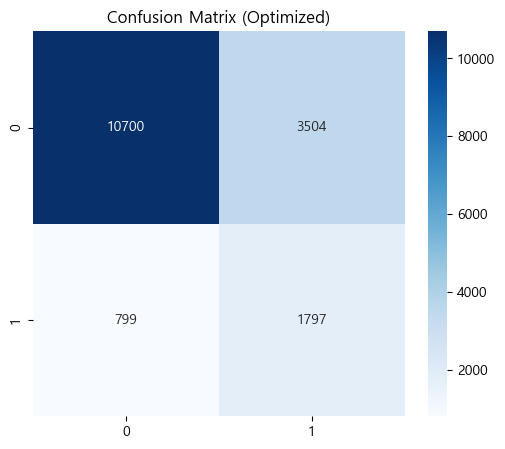


🔍 [Optimized Feature Importance - Top 30]
       Feature_Name  Importance
0          최종카드발급일자        3398
1          카드이용한도금액        2952
2      RV일시불이자율_할인전        2892
3         CL이자율_할인전        2730
4    RV현금서비스이자율_할인전        2705
5         CA이자율_할인전        2534
6            CA한도금액        2468
7           입회일자_신용        2334
8          월상환론한도금액        2161
9          상향가능한도금액        1633
10       상향가능CA한도금액        1538
11        일시상환론한도금액        1443
12       입회경과개월수_신용        1440
13        최종카드발급경과월        1411
14           최초한도금액         532
15       유효카드수_신용체크         451
16         유효카드수_체크         374
17         유효카드수_신용         308
18           OS구분코드         305
19     월상환론상향가능한도금액         187
20           남녀구분코드         177
21     보유여부_해외겸용_본인         131
22       수신거부여부_SMS         131
23    일시불ONLY전환가능여부         123
24      소지카드수_유효_신용         122
25        수신거부여부_TM         122
26      동의여부_한도증액안내         119
27        수신거부여부_DM         116
28  보유여부_해외겸용_신용_본인         1

(LGBMClassifier(colsample_bytree=0.5494060826092351,
                learning_rate=0.03976967168285498, max_depth=12, metric='auc',
                min_child_samples=49, n_estimators=689, n_jobs=-1, num_leaves=52,
                objective='binary', random_state=42, reg_alpha=8.135118136439486,
                reg_lambda=2.352674119049565e-08,
                scale_pos_weight=7.020884419375169, subsample=0.9969959322551866,
                verbosity=-1),
 <optuna.study.study.Study at 0x1cfdf90ef90>)

In [ ]:
tune_lgbm_with_optuna(df_train_final)

#### Optuna의 bestparams 활용
- 가중치 조정

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def train_best_model_manual_weight(input_data, manual_multiplier=1.28, random_state=42):
    """
    Optuna로 찾은 최적 파라미터를 고정하고, 가중치(Multiplier)만 조절하여 학습하는 함수
    :param manual_multiplier: 기본 비율(Neg/Pos)에 곱할 배수 (기본값 1.28은 Optuna 추천값)
    """
    print(f"\n{'='*20} [Fixed Params] Training with Multiplier: {manual_multiplier} {'='*20}")
    
    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None
    df_train = input_data.copy()

    # =========================================================
    # [Ultra-Strict] Leakage 변수 제거 (동일 로직 유지)
    # =========================================================
    manual_leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '_1순위카드이용건수', '_1순위업종_이용금액', '_1순위카드이용금액'
    ]
    
    auto_leakage_cols = []
    for col in df_train.columns:
        col_lower = col.lower()
        if re.search(r'[br]\d+m', col_lower): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['ratio', 'rate', '증감', '대비', 'yoy', 'mom', '비율', '소진율', '평균', '평잔', 'avg']):
            if not ('이자' in col or 'interest' in col_lower): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['금액', 'amt', 'price', 'pay', '납부', '청구', 'bill', '이용']):
            if not ('한도' in col or 'limit' in col_lower): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['건수', 'cnt', '횟수', 'count', 'frequency']): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['연속', '실적', 'coti', 'nout']): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['마케팅', '접촉', '컨택', 'contact', 'voc', '민원', '해지', '방어', '상담']): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['최종', '일자', '경과', 'date', 'day', 'elapsed']):
            if not ('가입' in col or '발급' in col or '입회' in col or 'join' in col_lower or 'issue' in col_lower):
                auto_leakage_cols.append(col)

    final_leakage_cols = list(set(manual_leakage_cols + auto_leakage_cols))
    
    # Data Split
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    try:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=random_state, stratify=unique_user_target['Target'])
    except:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=random_state)
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    cols_to_drop = [c for c in final_leakage_cols if c in df_train.columns]
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    # Base Ratio Calculation
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    base_ratio = n_neg / n_pos if n_pos > 0 else 1.0
    
    final_scale_pos_weight = base_ratio * manual_multiplier
    print(f" - [Weight Setting] Base Ratio: {base_ratio:.2f} x Multiplier: {manual_multiplier} = Final Weight: {final_scale_pos_weight:.2f}")

    # =========================================================
    # 🏆 Found Best Params (Fixed)
    # =========================================================
    best_params = {
        'learning_rate': 0.03976967168285498,
        'n_estimators': 689,
        'num_leaves': 52,
        'max_depth': 12,
        'min_child_samples': 49,
        'subsample': 0.9969959322551866,
        'colsample_bytree': 0.5494060826092351,
        'reg_alpha': 8.135118136439486,
        'reg_lambda': 2.352674119049565e-08,
        
        # 고정값
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': -1,
        
        # [수동 조절 대상]
        'scale_pos_weight': final_scale_pos_weight
    }

    # Model Training
    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Evaluation
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n📊 Performance (Multiplier={manual_multiplier})")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Multiplier: {manual_multiplier}')
    plt.show()
    
    return model


==================== [Fixed Params] Training with Multiplier: 1.7 ====================
 - [Weight Setting] Base Ratio: 5.47 x Multiplier: 1.7 = Final Weight: 9.30

📊 Performance (Multiplier=1.7)
 - Accuracy  : 0.6997
 - F1 Score  : 0.7398
 - ROC-AUC   : 0.7907
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     14204
           1       0.31      0.75      0.43      2596

    accuracy                           0.70     16800
   macro avg       0.62      0.72      0.62     16800
weighted avg       0.84      0.70      0.74     16800



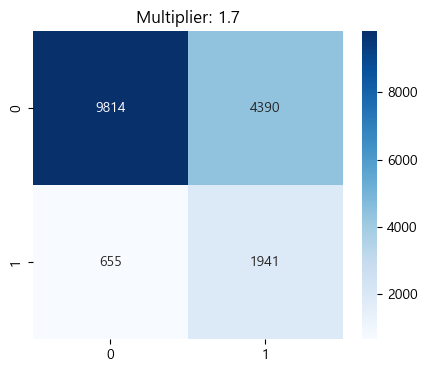

,boosting_type,'gbdt'
,num_leaves,52
,max_depth,12
,learning_rate,0.03976967168285498
,n_estimators,689
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,49


In [ ]:
train_best_model_manual_weight(df_train_final, manual_multiplier= 1.7)

#### 같은 조건 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def train_rf_model_manual_weight(input_data, manual_multiplier=1.28, random_state=42):
    """
    [RandomForest 버전] Ultra-Strict 모드 및 가중치 수동 조절 적용
    :param manual_multiplier: 기본 비율(Neg/Pos)에 곱할 배수 (1.0보다 크면 이탈자를 더 중요하게 봄)
    """
    print(f"\n{'='*20} [RandomForest] Training with Multiplier: {manual_multiplier} {'='*20}")
    
    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None
    df_train = input_data.copy()

    # =========================================================
    # [Ultra-Strict] Leakage 변수 제거 (LightGBM과 동일 로직)
    # =========================================================
    manual_leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '_1순위카드이용건수', '_1순위업종_이용금액', '_1순위카드이용금액'
    ]
    
    auto_leakage_cols = []
    for col in df_train.columns:
        col_lower = col.lower()
        if re.search(r'[br]\d+m', col_lower): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['ratio', 'rate', '증감', '대비', 'yoy', 'mom', '비율', '소진율', '평균', '평잔', 'avg']):
            if not ('이자' in col or 'interest' in col_lower): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['금액', 'amt', 'price', 'pay', '납부', '청구', 'bill', '이용']):
            if not ('한도' in col or 'limit' in col_lower): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['건수', 'cnt', '횟수', 'count', 'frequency']): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['연속', '실적', 'coti', 'nout']): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['마케팅', '접촉', '컨택', 'contact', 'voc', '민원', '해지', '방어', '상담']): auto_leakage_cols.append(col)
        elif any(x in col_lower for x in ['최종', '일자', '경과', 'date', 'day', 'elapsed']):
            if not ('가입' in col or '발급' in col or '입회' in col or 'join' in col_lower or 'issue' in col_lower):
                auto_leakage_cols.append(col)

    final_leakage_cols = list(set(manual_leakage_cols + auto_leakage_cols))
    
    # Data Split
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    try:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=random_state, stratify=unique_user_target['Target'])
    except:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=random_state)
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    cols_to_drop = [c for c in final_leakage_cols if c in df_train.columns]
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']
    
    print(f" - [RF Info] 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [RandomForest] Class Weight Calculation
    # =========================================================
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    base_ratio = n_neg / n_pos if n_pos > 0 else 1.0
    
    # RF는 딕셔너리 형태로 가중치를 받습니다.
    # 0(정상): 1.0, 1(이탈): base_ratio * manual_multiplier
    final_weight_for_1 = base_ratio * manual_multiplier
    class_weight_dict = {0: 1.0, 1: final_weight_for_1}
    
    print(f" - [Weight Setting] Class 0 Weight: 1.0")
    print(f" - [Weight Setting] Class 1 Weight: {final_weight_for_1:.2f} (Multiplier: {manual_multiplier})")

    # =========================================================
    # [RandomForest] Model Configuration (Speed Optimized)
    # =========================================================
    rf_params = {
        'n_estimators': 200,      # (최적화) 1000개는 너무 느림, 200개로 충분
        'max_depth': 15,          # (최적화) 너무 깊게 내려가지 않도록 제한 (과적합 방지 + 속도)
        'min_samples_split': 20,  # (최적화) 샘플이 적으면 분기하지 않음
        'min_samples_leaf': 10,   # (최적화) 리프 노드 최소 샘플 수
        'max_features': 'sqrt',   # 일반적으로 'sqrt'가 성능과 속도 균형이 좋음
        'bootstrap': True,
        'max_samples': 0.6,       # (속도 핵심) 각 트리가 전체 데이터의 60%만 보고 학습 (속도 대폭 향상)
        'class_weight': class_weight_dict,
        'random_state': random_state,
        'n_jobs': -1              # 모든 CPU 코어 사용
    }

    model = RandomForestClassifier(**rf_params)
    
    print(" - [Info] 학습 시작 (시간이 조금 걸릴 수 있습니다)...")
    model.fit(X_train, y_train)
    print("✅ 학습 완료!")
    
    # Evaluation
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n📊 Performance (RF, Multiplier={manual_multiplier})")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens') # RF는 초록색 테마
    plt.title(f'RandomForest (Multiplier: {manual_multiplier})')
    plt.show()

    # Feature Importance (Top 30)
    imp_df = pd.DataFrame({
        'Feature_Name': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print(f"\n🔍 [RF Feature Importance - Top 30]")
    print(imp_df.head(30).to_string())
    
    return model


==================== [RandomForest] Training with Multiplier: 1.28 ====================
 - [RF Info] 학습 Feature 수: 43개
 - [Weight Setting] Class 0 Weight: 1.0
 - [Weight Setting] Class 1 Weight: 7.00 (Multiplier: 1.28)
 - [Info] 학습 시작 (시간이 조금 걸릴 수 있습니다)...
✅ 학습 완료!

📊 Performance (RF, Multiplier=1.28)
 - Accuracy  : 0.7601
 - F1 Score  : 0.7844
 - ROC-AUC   : 0.7706
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     14204
           1       0.34      0.61      0.44      2596

    accuracy                           0.76     16800
   macro avg       0.63      0.70      0.64     16800
weighted avg       0.83      0.76      0.78     16800



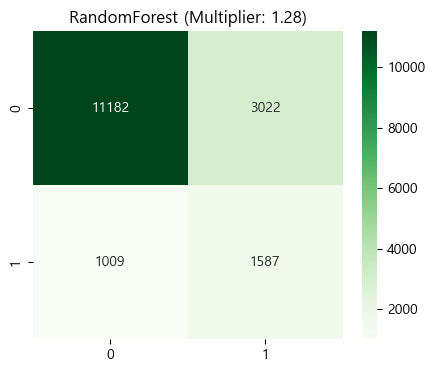


🔍 [RF Feature Importance - Top 30]
       Feature_Name  Importance
0          카드이용한도금액    0.141844
1            CA한도금액    0.098451
2          최종카드발급일자    0.069860
3      RV일시불이자율_할인전    0.053569
4    RV현금서비스이자율_할인전    0.051555
5         CL이자율_할인전    0.048272
6         최종카드발급경과월    0.044041
7          유효카드수_신용    0.043083
8         CA이자율_할인전    0.042835
9            OS구분코드    0.041939
10    일시불ONLY전환가능여부    0.039216
11      소지카드수_유효_신용    0.038837
12       입회경과개월수_신용    0.037069
13          입회일자_신용    0.036866
14         상향가능한도금액    0.032410
15       상향가능CA한도금액    0.029309
16         월상환론한도금액    0.028833
17       유효카드수_신용체크    0.017610
18        일시상환론한도금액    0.015620
19          소지여부_신용    0.012187
20       수신거부여부_SMS    0.007976
21         유효카드수_체크    0.007832
22  보유여부_해외겸용_신용_본인    0.007490
23      동의여부_한도증액안내    0.007212
24           최초한도금액    0.006687
25          연체일수_최근    0.006263
26           남녀구분코드    0.005524
27     월상환론상향가능한도금액    0.005206
28        수신거부여부_TM    0.004877
29  

,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
train_rf_model_manual_weight(df_train_final)

# 수정된 타겟 - 상태기반 4개

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_COUNT_SPEND = '이용건수_신판_B0M' # 빈도 소비 (할부, 일시불)
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT_SPEND].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT_SPEND].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    cond3 = scores['Score_Activity'] < 0
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond3) + int(cond4)
    cond_high_risk = (risk_count >= 1)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")

    return df_res,df

In [ ]:
TEST_FILE = '../../../260108/general_combined_part1.csv'
df_res, df = analyze_rolling_churn(TEST_FILE)


[Info] 파일 로드 및 분석 시작: ../../../260108/general_combined_part1.csv
 - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)


C:\Users\johnh\AppData\Local\Temp\ipykernel_24996\2882551176.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100



📊 이탈자 Rolling 분석 결과 (대상 파일: general_combined_part1.csv)
 - 총 분석 고객 수: 84000명
 - 최종 시점 이탈자 수: 33447명 (39.82%)
------------------------------
 [이탈 징후 지속 기간 통계]
count    33447.000000
mean         2.197925
std          1.617655
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: Churn_Duration_Months, dtype: float64
------------------------------
 [기간별 분포 (상위 10개)]
Churn_Duration_Months
6     2872
5     1934
4     1439
3     3085
2     7484
1    16633
Name: count, dtype: int64

✅ 상세 결과 저장 완료: churn_duration_results_general_combined_part1.csv


(          Cust_ID  Churn_Duration_Months
 0      SYN_104768                      2
 1      SYN_104772                      1
 2      SYN_104773                      1
 3      SYN_104776                      3
 4      SYN_104777                      5
 ...           ...                    ...
 33442  SYN_209532                      1
 33443  SYN_209542                      1
 33444  SYN_209543                      2
 33445  SYN_209551                      1
 33446  SYN_209555                      3
 
 [33447 rows x 2 columns],
             발급회원번호    기준년월  컨택건수_카드론_TM_B0M  컨택건수_리볼빙_TM_B0M  컨택건수_CA_TM_B0M  \
 0       SYN_104767  201807                0                0               0   
 84000   SYN_104767  201808                0                0               0   
 168000  SYN_104767  201809                0                0               0   
 252000  SYN_104767  201810                0                0               0   
 336000  SYN_104767  201811                0                0 

In [7]:
TRAIN_FILE = '../../../260108/general_combined_part1.csv'

## 모델 학습

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도(카드론, 현금서비스 포함)
COL_COUNT_SPEND = '이용건수_신판_B0M' # 소비건수 (할부+일시불)
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT_SPEND].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT_SPEND].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def process_data(file_path):
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. 데이터 로드
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

    # 2. 컬럼 확인
    required_cols = [
        COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_COUNT_SPEND, COL_BALANCE, 
        COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
        COL_SPEND_R12M, COL_COUNT_R12M
    ]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        print(f"⚠️ 일부 컬럼 누락 (0으로 대체): {missing_cols}")
        for c in missing_cols:
            df[c] = 0

    # 3. 데이터 정렬
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    print(" - 고객별 지표(Slopes, Scores) 산출 중... (R12M 보완 로직 적용됨)")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # 4. Target 생성 로직 적용
    print(" - Target 생성 중...")
    
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 1개 이상 감지
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    # Target 할당
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - 완료: {len(df_scores)}명 데이터 생성됨.")
    print(f" - Target 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    return df_scores, df


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_COUNT_SPEND = '이용건수_신판_B0M' # 빈도 소비 (할부, 일시불)
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT_SPEND].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT_SPEND].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    cond3 = scores['Score_Activity'] < 0
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond3) + int(cond4)
    cond_high_risk = (risk_count >= 1)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")

    return df_res,df

In [8]:
df_result, df_raw = analyze_rolling_churn(TRAIN_FILE)


[Info] 파일 로드 및 분석 시작: ../../../260108/general_combined_part1.csv
 - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)


C:\Users\johnh\AppData\Local\Temp\ipykernel_24996\2882551176.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100



📊 이탈자 Rolling 분석 결과 (대상 파일: general_combined_part1.csv)
 - 총 분석 고객 수: 84000명
 - 최종 시점 이탈자 수: 33447명 (39.82%)
------------------------------
 [이탈 징후 지속 기간 통계]
count    33447.000000
mean         2.197925
std          1.617655
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: Churn_Duration_Months, dtype: float64
------------------------------
 [기간별 분포 (상위 10개)]
Churn_Duration_Months
6     2872
5     1934
4     1439
3     3085
2     7484
1    16633
Name: count, dtype: int64

✅ 상세 결과 저장 완료: churn_duration_results_general_combined_part1.csv


In [9]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33447 entries, 0 to 33446
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Cust_ID                33447 non-null  object
 1   Churn_Duration_Months  33447 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 522.7+ KB


In [10]:
# 1. 함수 실행
# df_result, df_raw = analyze_rolling_churn("파일경로.csv")

# 2. 이탈 확정된 고객(Target=1)의 ID만 리스트로 추출
churn_ids = df_result['Cust_ID'].unique()

# 3. 원본 데이터에 '이탈자 표시' 컬럼 추가 (Target 컬럼 생성)
# -> ID가 df_result에 있는 사람이면 1, 아니면 0
df_raw['Target'] = df_raw[COL_ID].isin(churn_ids).astype(int)

# 4. 이제 df_raw를 가지고 시각화나 모델링에 사용!
print(df_raw['Target'].value_counts())

Target
0    303318
1    200682
Name: count, dtype: int64


In [11]:
# =========================================================
# [수정됨] 특정 이탈자의 이탈 발생 시점(Target=1) 조회
# =========================================================

# 1. 원본(df_raw)에 이탈 지속 기간 정보(df_result)를 붙이기
df_merged = pd.merge(df_raw, df_result[['Cust_ID', 'Churn_Duration_Months']], 
                     left_on=COL_ID, right_on='Cust_ID', how='left')

# 2. 이탈 기간만큼 뒤에서부터 Target=1 마킹하는 함수
def mark_churn_target(group):
    # 이 고객의 이탈 지속 기간 가져오기
    duration = group['Churn_Duration_Months'].iloc[0]
    
    # Target 컬럼 초기화 (기본 0)
    group['Target'] = 0
    
    # 이탈 기간(duration)이 존재하면, 데이터의 끝에서부터 그 기간만큼 1로 변경
    if pd.notnull(duration) and duration > 0:
        group.iloc[-int(duration):, group.columns.get_loc('Target')] = 1
        
    return group

# 3. 전체 데이터에 마킹 로직 적용
print(" - 이탈 시점 마킹 중... (잠시만 기다려주세요)")

# [수정 포인트] .reset_index(drop=True)를 추가하여 인덱스/컬럼 중복 충돌 방지
df_final = df_merged.groupby(COL_ID).apply(mark_churn_target).reset_index(drop=True)

# 4. 보고 싶은 컬럼만 남기기
df_view = df_final[[COL_ID, COL_DATE, 'Target']].sort_values(by=[COL_ID, COL_DATE])

# ---------------------------------------------------------
# [결과 출력] 첫 번째 이탈자를 샘플로 뽑아서 확인
# ---------------------------------------------------------
if len(df_result) > 0:
    # 이탈자 명단에서 첫 번째 사람 ID 추출
    sample_id = df_result['Cust_ID'].iloc[0]
    
    print(f"\n📊 [{sample_id}] 회원의 이탈 시점 확인")
    print("-" * 40)
    # 해당 회원의 데이터만 필터링해서 출력
    print(df_view[df_view[COL_ID] == sample_id].to_string(index=False))
    print("-" * 40)
else:
    print("❌ 이탈자가 한 명도 없습니다.")

 - 이탈 시점 마킹 중... (잠시만 기다려주세요)


C:\Users\johnh\AppData\Local\Temp\ipykernel_24996\885221372.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df_merged.groupby(COL_ID).apply(mark_churn_target).reset_index(drop=True)



📊 [SYN_104768] 회원의 이탈 시점 확인
----------------------------------------
    발급회원번호   기준년월  Target
SYN_104768 201807       0
SYN_104768 201808       0
SYN_104768 201809       0
SYN_104768 201810       0
SYN_104768 201811       1
SYN_104768 201812       1
----------------------------------------


In [12]:
df_final.head()

,발급회원번호,기준년월,컨택건수_카드론_TM_B0M,컨택건수_리볼빙_TM_B0M,컨택건수_CA_TM_B0M,컨택건수_이용유도_TM_B0M,컨택건수_신용발급_TM_B0M,컨택건수_부대서비스_TM_B0M,컨택건수_포인트소진_TM_B0M,컨택건수_보험_TM_B0M,...,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월,Target,Cust_ID,Churn_Duration_Months
0,SYN_104767,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,1,6.자녀출가기,4,0,NaN,NaN
1,SYN_104767,201808,0,0,0,0,0,0,0,0,...,0,0,0,0,1,6.자녀출가기,5,0,NaN,NaN
2,SYN_104767,201809,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6.자녀출가기,6,0,NaN,NaN
3,SYN_104767,201810,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6.자녀출가기,7,0,NaN,NaN
4,SYN_104767,201811,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6.자녀출가기,8,0,NaN,NaN


In [13]:
df_final.drop(columns=['Cust_ID','Churn_Duration_Months'], inplace=True)

In [14]:
# 2. [추가] 이탈자로 판명된 사람(Cust_ID가 df_result에 있는 사람)만 필터링
# df_result['Cust_ID']에는 이미 이탈자 명단만 들어있으므로, 이걸 이용하면 빠릅니다.
churn_cust_ids = df_result['Cust_ID'].unique()

# 이탈자 명단에 있는 사람의 데이터만 남김
df_churn_only = df_final[df_final[COL_ID].isin(churn_cust_ids)].copy()

# 3. 정렬 및 확인
df_view = df_churn_only[[COL_ID, COL_DATE, 'Target']].sort_values(by=[COL_ID, COL_DATE])

print(f"전체 고객 수: {len(df_final[COL_ID].unique())}명")
print(f"필터링된 이탈자 수: {len(df_view[COL_ID].unique())}명")

# 결과 확인
print(df_view.head(20))

전체 고객 수: 84000명
필터링된 이탈자 수: 33447명
        발급회원번호    기준년월  Target
6   SYN_104768  201807       0
7   SYN_104768  201808       0
8   SYN_104768  201809       0
9   SYN_104768  201810       0
10  SYN_104768  201811       1
11  SYN_104768  201812       1
24  SYN_104772  201807       0
25  SYN_104772  201808       0
26  SYN_104772  201809       0
27  SYN_104772  201810       0
28  SYN_104772  201811       0
29  SYN_104772  201812       1
30  SYN_104773  201807       0
31  SYN_104773  201808       0
32  SYN_104773  201809       0
33  SYN_104773  201810       0
34  SYN_104773  201811       0
35  SYN_104773  201812       1
48  SYN_104776  201807       0
49  SYN_104776  201808       0


In [15]:
df_churn_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200682 entries, 6 to 503999
Columns: 847 entries, 발급회원번호 to Target
dtypes: float64(62), int64(756), object(29)
memory usage: 1.3+ GB


In [16]:
df_final.head()

,발급회원번호,기준년월,컨택건수_카드론_TM_B0M,컨택건수_리볼빙_TM_B0M,컨택건수_CA_TM_B0M,컨택건수_이용유도_TM_B0M,컨택건수_신용발급_TM_B0M,컨택건수_부대서비스_TM_B0M,컨택건수_포인트소진_TM_B0M,컨택건수_보험_TM_B0M,...,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월,Target
0,SYN_104767,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6.자녀출가기,4,0
1,SYN_104767,201808,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6.자녀출가기,5,0
2,SYN_104767,201809,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.자녀출가기,6,0
3,SYN_104767,201810,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.자녀출가기,7,0
4,SYN_104767,201811,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.자녀출가기,8,0


In [17]:
df_final[['발급회원번호','기준년월','Target']]

,발급회원번호,기준년월,Target
0,SYN_104767,201807,0
1,SYN_104767,201808,0
2,SYN_104767,201809,0
3,SYN_104767,201810,0
4,SYN_104767,201811,0
...,...,...,...
503995,SYN_209555,201808,0
503996,SYN_209555,201809,0
503997,SYN_209555,201810,1
503998,SYN_209555,201811,1


In [18]:
# df_churn_only.to_csv('general_churn_전체.csv', index=False)

In [19]:
# # 2. Target이 1인 데이터(이탈 위험군)만 추출
# # 문법: 데이터프레임[조건]
# churn_df = df_scores[df_scores['Target'] == 1]

# # 3. 결과 확인
# print(f"전체 고객 수: {len(df_scores)}명")
# print(f"이탈 위험군(Target=1) 수: {len(churn_df)}명")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run_rf_simulation_final(data, drop_cols=[]):
    """
    data: 학습에 사용할 전체 데이터프레임 (Target 포함)
    drop_cols: 학습에서 제외할 컬럼 리스트 (Data Leakage 유발 컬럼들)
    """
    print(f"[Info] 모델 학습 시작")
    print(f" - 제외할 컬럼(Leakage): {len(drop_cols)}개")
    
    # 1. 데이터 전처리 (결측치/무한대 처리)
    data_clean = data.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # 2. X, y 분리
    # [핵심] ID, Target 뿐만 아니라 사용자가 정의한 drop_cols도 함께 제거합니다.
    # errors='ignore': 리스트에 있는 컬럼이 실제 데이터에 없어도 에러 없이 넘어가게 함
    drop_target = ['Cust_ID', 'Target'] + drop_cols
    X = data_clean.drop(columns=drop_target, errors='ignore')
    y = data_clean['Target']
    
    print(f" - 최종 학습 Feature 개수: {X.shape[1]}개")
    print(f" - 학습 Feature 목록(일부): {X.columns.tolist()[:5]} ...")
    
    # 3. Train / Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 4. 모델 학습 (Real Prediction Mode)
    # 이제 정답지가 없으므로, 과적합 방지를 위해 파라미터를 조금 더 조절합니다.
    rf = RandomForestClassifier(
        n_estimators=200,    # 트리를 좀 더 많이
        max_depth=10,        # 깊이 제한 (너무 깊으면 과적합)
        min_samples_leaf=4,  # 리프 노드 최소 샘플 수 (일반화 성능 향상)
        random_state=42,
        class_weight='balanced',
        n_jobs=-1            # 병렬 처리로 속도 향상
    )
    
    rf.fit(X_train, y_train)
    
    # 5. 예측 및 평가
    y_pred = rf.predict(X_test)
    
    print("\n" + "="*50)
    print("📊 최종 모델 평가 결과 (Leakage 제거됨)")
    print("="*50)
    print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    
    # 6. Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Real Prediction)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # 7. Feature Importance
    # 점수(Score)가 빠졌으니, 이제 원본 변수 중 무엇이 중요한지 나옵니다.
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # 상위 20개만 시각화
    top_n = 20
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances[indices][:top_n], y=X.columns[indices][:top_n], palette='viridis')
    plt.title(f'Top {top_n} Feature Importance (Without Leakage)')
    plt.xlabel('Importance')
    plt.show()
    
    return rf

# =========================================================
# [사용 방법]
# 1. 제외할 컬럼 리스트를 정의하세요 (사용자가 찾은 Feature Importance 상위 변수들 등)
# 예시: leakage_cols = ['Slope_Spend', 'Slope_Balance', 'Score_Total', 'Score_BadDebt', ...]
# =========================================================

# 여기에 직접 정의하신 컬럼 리스트를 넣으시면 됩니다.
# leakage_cols = [
#     'Slope_Spend', 'Slope_Balance', 'Slope_Count',
#     'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset', 
#     'Score_Status_Total'
# ]

# 실행
# model_final = run_rf_simulation_final(df_ml, drop_cols=leakage_cols)

In [1]:
def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed. Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [수정] scale_pos_weight 자동 계산 로직 추가
    # =========================================================
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    
    # 기본 비율 계산 (Negative 수 / Positive 수)
    # 0으로 나누는 것을 방지하기 위한 안전장치 추가
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    
    # 튜닝 포인트: 이탈자를 더 강력하게 잡고 싶다면 ratio * 1.5, ratio * 2.0 등으로 높이세요.
    final_scale_pos_weight = ratio * 1.1
    
    print(f" - [Info] 자동 계산된 Class Ratio (Neg/Pos): {ratio:.2f}")
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")
    # =========================================================

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced',    # <-- [삭제] 이것 대신 아래 scale_pos_weight 사용
        # 'scale_pos_weight': final_scale_pos_weight  # <-- [추가]
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

In [22]:
# 파일 경로 (수정 필요)
TRAIN_FILE = '../../../260108/general_combined_part1.csv' # Example file

In [23]:
df_train_final = process_data_and_merge(TRAIN_FILE)


[Info] 파일 로드 및 전처리 시작: ../../../260108/general_combined_part1.csv
 - Target 산출 (R12M 보완 로직)...


C:\Users\johnh\AppData\Local\Temp\ipykernel_24996\2882551176.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
C:\Users\johnh\AppData\Local\Temp\ipykernel_24996\2464839603.py:160: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


 - Target 생성 완료. 비율: {0: 0.6018214285714286, 1: 0.39817857142857144}
 - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...



==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 802개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 1.51
 - [Info] 적용된 scale_pos_weight: 1.66
✅ 학습 완료 (소요시간: 12.45초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7505
 - F1 Score  : 0.7531
 - ROC-AUC   : 0.8381
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.72      0.78     10111
           1       0.65      0.80      0.72      6689

    accuracy                           0.75     16800
   macro avg       0.75      0.76      0.75     16800
weighted avg       0.77      0.75      0.75     16800



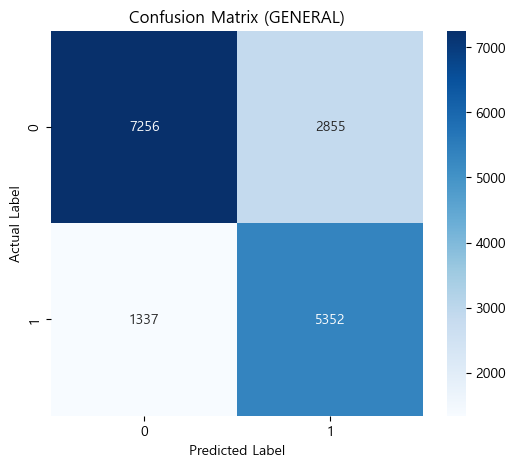

<Figure size 1000x800 with 0 Axes>

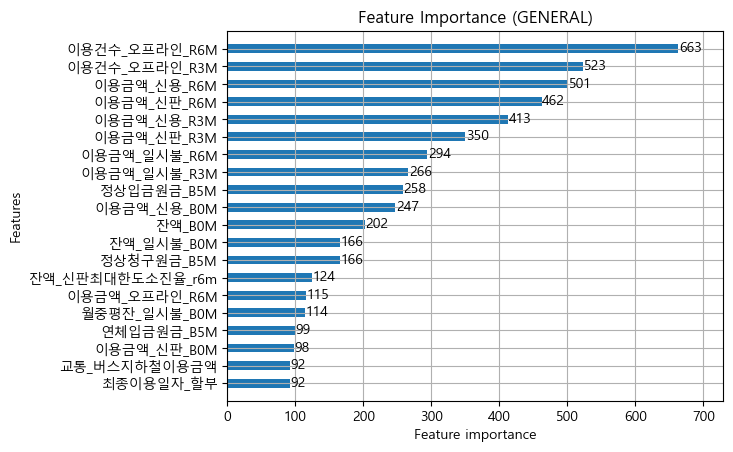

In [27]:
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)


==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 403200개, Test 데이터 수: 100800개
 - 최종 학습 Feature 수: 802개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 5.85
 - [Info] 적용된 scale_pos_weight: 6.43
✅ 학습 완료 (소요시간: 54.54초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7936
 - F1 Score  : 0.8210
 - ROC-AUC   : 0.9151
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     86156
           1       0.41      0.91      0.56     14644

    accuracy                           0.79    100800
   macro avg       0.69      0.84      0.71    100800
weighted avg       0.90      0.79      0.82    100800



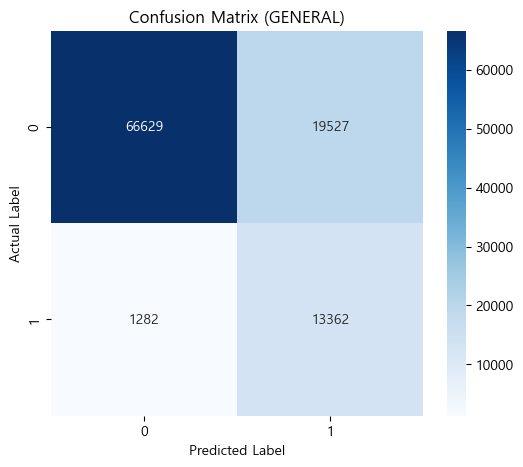

<Figure size 1000x800 with 0 Axes>

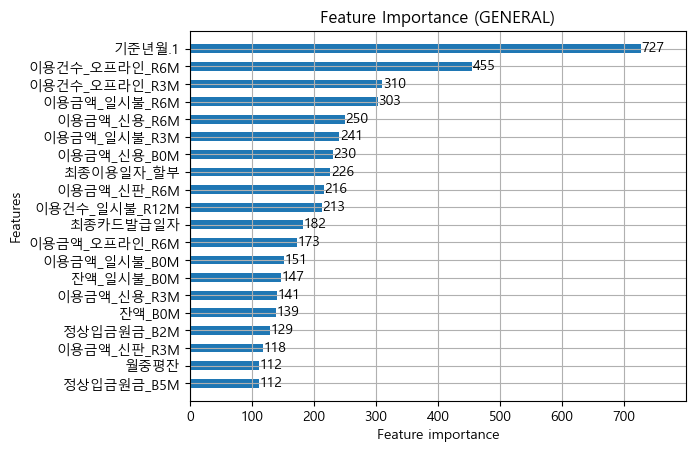

(LGBMClassifier(class_weight='balanced', device='cpu', learning_rate=0.05,
                n_estimators=400, n_jobs=-1, random_state=42, verbose=-1),
 (0.7935615079365079, 0.8209575568218331, 0.915093004971867))

In [28]:
train_eval_lgbm_general_group_split(df_final)

In [29]:
df_final.drop(['기준년월.1','기준년월.2','기준년월.3','기준년월.4','기준년월.5','기준년월.6'], axis=1, inplace=True)

#### 임계값 수정

In [30]:
def train_eval_lgbm_general_group_split_threshold(input_data, group_name='GENERAL', device_type='cpu', threshold=0.5):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    print(f"👉 적용된 분류 임계값(Threshold): {threshold} (이 값 이상일 때 이탈로 판정)")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed. Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [수정] scale_pos_weight 자동 계산
    # =========================================================
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    final_scale_pos_weight = ratio * 1.1
    
    print(f" - [Info] 자동 계산된 Class Ratio (Neg/Pos): {ratio:.2f}")
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        # 'class_weight': 'balanced',    
        'scale_pos_weight': final_scale_pos_weight # 주석 해제하여 적용
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가 (임계값 적용 부분)
    # y_pred = model.predict(X_test)  <-- 기존: 무조건 0.5 기준
    
    # [수정됨] 확률값(Proba)을 먼저 구하고, threshold와 비교하여 0/1 생성
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # 클래스 불균형 시 binary 추천하지만 weighted 요청 유지
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report (Threshold={threshold})")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name}) @ Thresh={threshold}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)


==================== [GENERAL] Training Start (Group-based Split) ====================
👉 적용된 분류 임계값(Threshold): 0.45 (이 값 이상일 때 이탈로 판정)
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 403200개, Test 데이터 수: 100800개
 - 최종 학습 Feature 수: 796개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 5.85
 - [Info] 적용된 scale_pos_weight: 6.43
✅ 학습 완료 (소요시간: 58.13초)

📊 [GENERAL] Model Performance Report (Threshold=0.45)
 - Accuracy  : 0.7577
 - F1 Score  : 0.7921
 - ROC-AUC   : 0.9041
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     86156
           1       0.37      0.93      0.53     14644

    accuracy                           0.76    100800
   macro avg       0.68      0.83      0.68    100800
weighted avg       0.89      0.76      0.79    100800



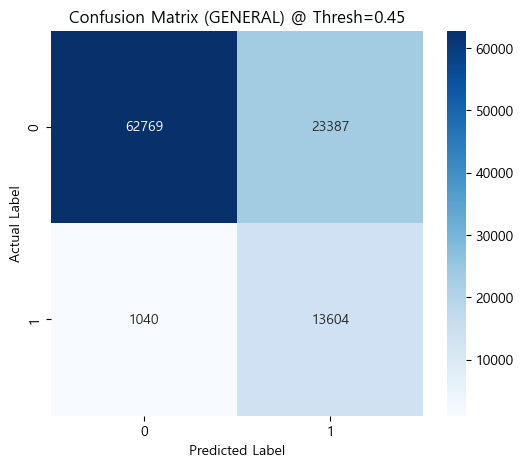

<Figure size 1000x800 with 0 Axes>

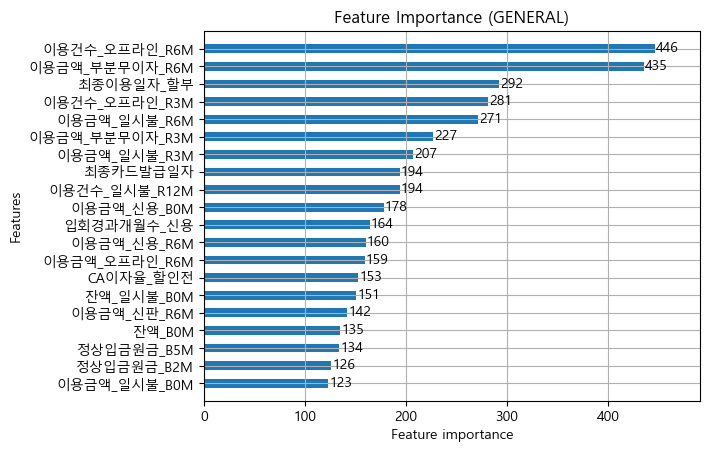

(LGBMClassifier(device='cpu', learning_rate=0.05, n_estimators=400, n_jobs=-1,
                random_state=42, scale_pos_weight=6.433888228299644, verbose=-1),
 (0.7576686507936508, 0.7920522059628846, 0.9040689971624748))

In [31]:
train_eval_lgbm_general_group_split_threshold(df_final, threshold= 0.45)

In [32]:
from sklearn.metrics import precision_score, recall_score

def lighgbm_threshold_compare(input_data, group_name='GENERAL', device_type='cpu', thresholds=[0.5]):
    """
    thresholds: 
        - 단일 값 (예: 0.5) -> 해당 임계값으로 예측 및 평가
        - 리스트 (예: [0.3, 0.4, 0.5]) -> 여러 임계값 비교 분석 및 시각화
    """
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # ---------------------------------------------------------
    # 1. 데이터 준비 및 전처리
    # ---------------------------------------------------------
    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None, None
        
    df_train = input_data.copy()
    
    # Leakage 및 불필요 컬럼 제거
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None

    # Group Split
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    try:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=42, stratify=unique_user_target['Target'])
    except:
        train_ids, test_ids = train_test_split(unique_user_target['발급회원번호'], test_size=0.2, random_state=42)
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train: {len(df_train_sub)}건, Test: {len(df_test_sub)}건")

    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    # scale_pos_weight 자동 계산
    ratio = (len(y_train) - y_train.sum()) / y_train.sum() if y_train.sum() > 0 else 1.0
    final_scale_pos_weight = ratio * 1.1

    # ---------------------------------------------------------
    # 2. 모델 학습
    # ---------------------------------------------------------
    params = {
        'n_estimators': 400, 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1,
        'random_state': 42, 'n_jobs': -1, 'device': device_type, 'verbose': -1,
        'scale_pos_weight': final_scale_pos_weight
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    print("✅ 학습 완료")

    # ---------------------------------------------------------
    # 3. 임계값 비교 분석 및 시각화 (핵심 기능)
    # ---------------------------------------------------------
    
    # 단일 값이 들어오면 리스트로 변환
    if not isinstance(thresholds, list):
        thresholds = [thresholds]
        
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results = []
    
    print(f"\n🔍 [Threshold Analysis] {len(thresholds)}개 임계값 비교 중...")
    
    for th in thresholds:
        y_pred = (y_prob >= th).astype(int)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary') # 이탈(1)에 대한 F1
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred)
        
        results.append({
            'Threshold': th,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1_Score': f1
        })
        
    df_results = pd.DataFrame(results)
    
    # 결과 출력 (F1 점수가 높은 순으로 정렬)
    print("\n📊 임계값별 성능 비교 (Top 5 by F1 Score)")
    print(df_results.sort_values(by='F1_Score', ascending=False).head(5).to_string(index=False))
    
    # ---------------------------------------------------------
    # 4. 시각화 (Line Chart)
    # ---------------------------------------------------------
    if len(thresholds) > 1:
        plt.figure(figsize=(10, 6))
        
        # 지표별 그래프 그리기
        plt.plot(df_results['Threshold'], df_results['Precision'], marker='o', label='Precision (정밀도)')
        plt.plot(df_results['Threshold'], df_results['Recall'], marker='s', label='Recall (재현율)')
        plt.plot(df_results['Threshold'], df_results['F1_Score'], marker='^', label='F1 Score (조화평균)', linewidth=3, color='red')
        plt.plot(df_results['Threshold'], df_results['Accuracy'], marker='x', linestyle='--', label='Accuracy (정확도)', color='gray', alpha=0.5)
        
        # 최적점 표시 (F1 최대 지점)
        best_row = df_results.loc[df_results['F1_Score'].idxmax()]
        plt.axvline(best_row['Threshold'], color='red', linestyle=':', label=f"Best F1 ({best_row['Threshold']})")
        
        plt.title(f'Performance Metrics by Threshold ({group_name})')
        plt.xlabel('Threshold (임계값)')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Feature Importance (마지막 모델 기준)
    # plt.figure(figsize=(10, 6))
    # lgb.plot_importance(model, max_num_features=15, title=f'Feature Importance ({group_name})')
    # plt.show()

    return model, df_results


==================== [GENERAL] Training Start (Group-based Split) ====================
 - Train: 403200건, Test: 100800건
✅ 학습 완료

🔍 [Threshold Analysis] 4개 임계값 비교 중...

📊 임계값별 성능 비교 (Top 5 by F1 Score)
 Threshold  Accuracy  Precision   Recall  F1_Score
      0.50  0.774683   0.383706 0.908905  0.539609
      0.45  0.757669   0.367765 0.928981  0.526929
      0.40  0.740933   0.353475 0.944756  0.514465
      0.35  0.723770   0.340225 0.959710  0.502359


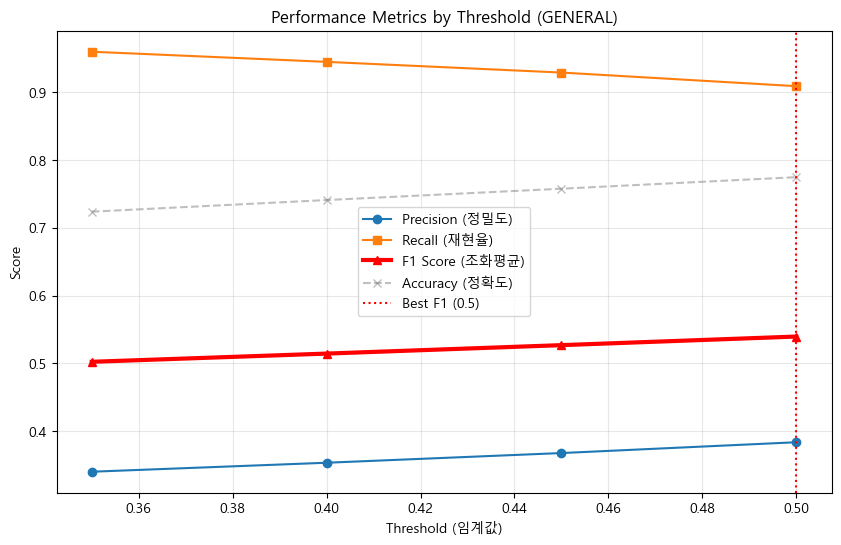

In [43]:
model_threshold, df_results_threshold = lighgbm_threshold_compare(df_final, thresholds=[0.35,0.4,0.45,0.5])

#### 가중치, threshold 설정

In [34]:
import math
import gc
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def compare_lgbm_weights_opt(input_data, weights=None, group_name='GENERAL', device_type='cpu', threshold=0.5):
    """
    [메모리 최적화 버전]
    불필요한 데이터 복사(copy)를 제거하여 MemoryError 방지
    """
    print(f"\n{'='*20} [{group_name}] Weight Comparison (Optimized) {'='*20}")
    
    if weights is None:
        weights = ['balanced']
        print("👉 가중치 기본값 ['balanced'] 설정")

    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None

    # 1. Leakage 컬럼 정의
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]
    
    if 'Target' not in input_data.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None

    # 2. Feature 컬럼 미리 식별 (데이터 복사 없이 이름만 추출)
    # 숫자형 컬럼 중 leakage에 포함되지 않는 것만 선택
    numeric_cols = input_data.select_dtypes(include=['number']).columns
    feature_cols = [c for c in numeric_cols if c not in leakage_cols]
    
    print(f" - 학습에 사용할 Feature 수: {len(feature_cols)}개")

    # 3. Group Split (ID 기준 분리)
    # ID와 Target만 있는 아주 가벼운 데이터프레임으로 분리 기준 생성
    print(" - 데이터 분리 중...")
    unique_user_target = input_data[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    # 4. [핵심 최적화] 원본에서 필요한 행/열만 직접 슬라이싱 (중간 복사본 생성 X)
    # isin으로 마스크(True/False)만 생성
    train_mask = input_data['발급회원번호'].isin(train_ids)
    test_mask = input_data['발급회원번호'].isin(test_ids)
    
    # 여기서만 메모리 할당 발생 (Train/Test Set 생성)
    X_train = input_data.loc[train_mask, feature_cols]
    y_train = input_data.loc[train_mask, 'Target']
    
    X_test = input_data.loc[test_mask, feature_cols]
    y_test = input_data.loc[test_mask, 'Target']
    
    print(f" - Train: {len(X_train)}건, Test: {len(X_test)}건")
    
    # 메모리 청소
    gc.collect()

    # ---------------------------------------------------------
    # 5. 모델 학습 및 평가 Loop
    # ---------------------------------------------------------
    results = []
    confusion_matrices = []
    
    for w in tqdm(weights, desc="Training Models"):
        params = {
            'n_estimators': 400, 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1,
            'random_state': 42, 'n_jobs': -1, 'device': device_type, 'verbose': -1
        }
        
        current_weight_label = str(w)
        if w == 'balanced':
            params['class_weight'] = 'balanced'
        else:
            params['scale_pos_weight'] = float(w)
            
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results.append({
            'Weight': current_weight_label,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1_Score': f1
        })
        confusion_matrices.append((current_weight_label, cm))
    
    # 결과 출력
    df_results = pd.DataFrame(results)
    print("\n📊 가중치별 성능 비교 (F1 Score 내림차순)")
    print(df_results.sort_values(by='F1_Score', ascending=False).to_string(index=False))
    
    # 시각화
    n_weights = len(weights)
    n_cols = 3
    n_rows = math.ceil(n_weights / n_cols)
    
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    
    for i, (label, cm) in enumerate(confusion_matrices):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f"Weight: {label}\n(F1: {df_results[df_results['Weight']==label]['F1_Score'].values[0]:.4f})", fontsize=12, fontweight='bold')
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
        
    plt.tight_layout()
    plt.show()
    
    return df_results


==================== [GENERAL] Weight Comparison (Optimized) ====================
 - 학습에 사용할 Feature 수: 796개
 - 데이터 분리 중...
 - Train: 403200건, Test: 100800건


Training Models: 100%|██████████| 4/4 [03:16<00:00, 49.21s/it]



📊 가중치별 성능 비교 (F1 Score 내림차순)
  Weight  Accuracy  Precision   Recall  F1_Score
balanced  0.781944   0.390911 0.897569  0.544626
     1.4  0.875397   0.580838 0.511267  0.543837
     1.2  0.878016   0.612733 0.435742  0.509298
     1.0  0.878224   0.653413 0.344510  0.451151


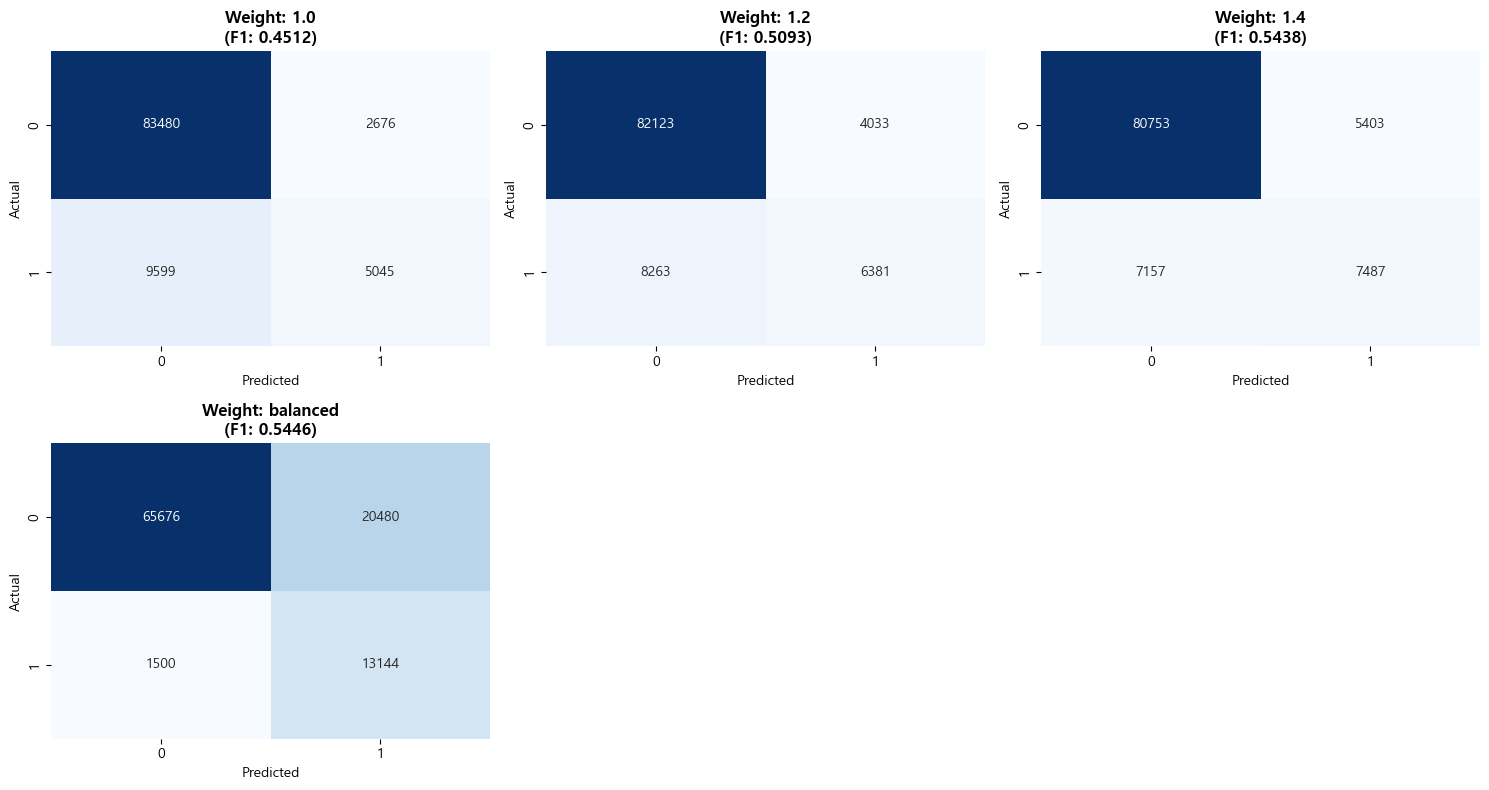

,Weight,Accuracy,Precision,Recall,F1_Score
0,1.0,0.878224,0.653413,0.344510,0.451151
1,1.2,0.878016,0.612733,0.435742,0.509298
2,1.4,0.875397,0.580838,0.511267,0.543837
3,balanced,0.781944,0.390911,0.897569,0.544626


In [35]:
compare_lgbm_weights_opt(df_final, weights=[1.0, 1.2, 1.4, 'balanced'])

#### shap/vif 지수 확인


==================== SHAP Analysis (Fixed) ====================
👉 전체 504000개 중 1000개를 랜덤 추출하여 분석합니다.
 - 모델이 학습한 Feature 수: 802개
⚠️ [경고] 다음 컬럼이 데이터에 없습니다: ['기준년월.1', '기준년월.2', '기준년월.3', '기준년월.4', '기준년월.5', '기준년월.6']
   -> 0으로 채워서 진행합니다 (정확도가 떨어질 수 있음)
 - 분석 대상 Feature 수: 802개 (모델과 일치)
 - SHAP 값 계산 중... (잠시만 기다려주세요)


c:\Users\johnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



📊 [1] Summary Plot (변수별 영향력 방향)


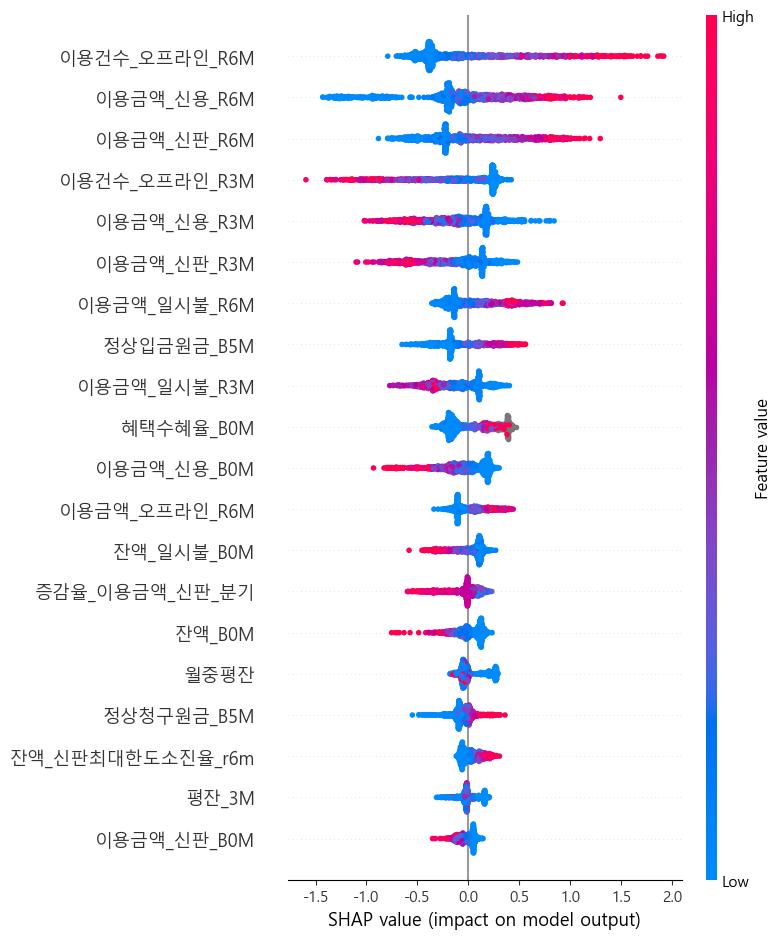


📊 [2] Bar Plot (변수 중요도 순위)


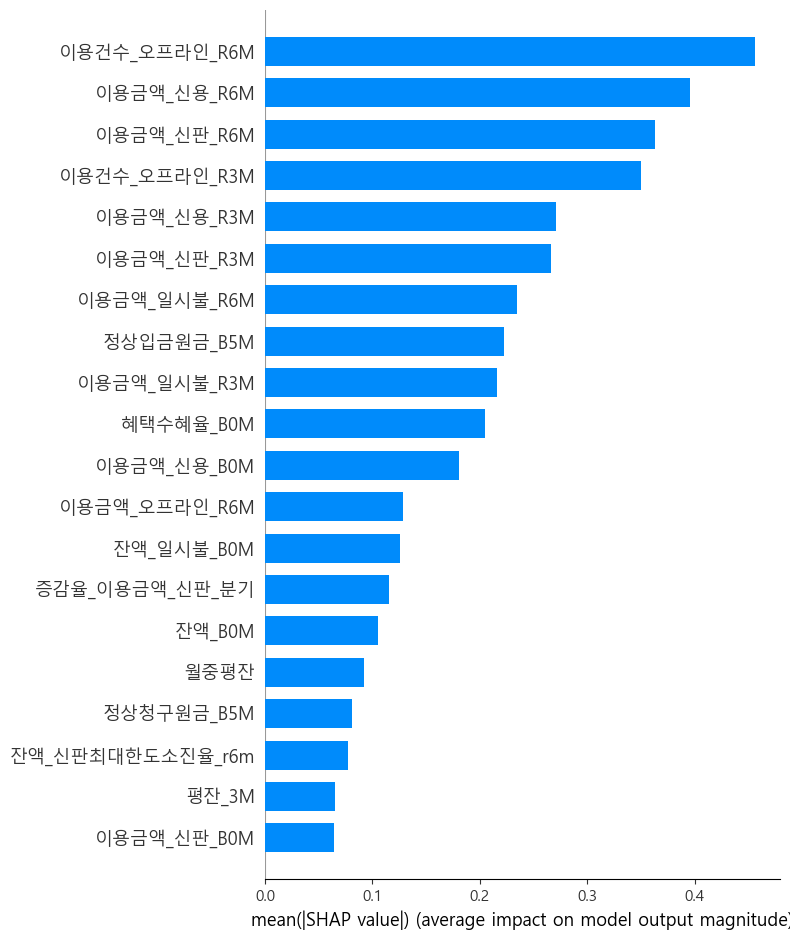

In [42]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def analyze_shap_lightgbm_fixed(df, model, n_samples=1000):
    print(f"\n{'='*20} SHAP Analysis (Fixed) {'='*20}")
    
    # 1. 데이터 샘플링
    if len(df) > n_samples:
        df_sample = df.sample(n=n_samples, random_state=42)
        print(f"👉 전체 {len(df)}개 중 {n_samples}개를 랜덤 추출하여 분석합니다.")
    else:
        df_sample = df.copy()
        print(f"👉 데이터가 {len(df)}개이므로 전체를 분석합니다.")

    # =========================================================
    # [핵심 수정] 모델이 학습할 때 사용한 Feature 이름 그대로 가져오기
    # =========================================================
    try:
        # LightGBM 모델에서 학습된 변수명 리스트 추출
        model_features = model.feature_name_
        print(f" - 모델이 학습한 Feature 수: {len(model_features)}개")
        
        # 데이터프레임에서 해당 컬럼들만 선택 (순서도 모델과 똑같이 맞춤)
        # 만약 df에 없는 컬럼이 있다면 에러가 날 수 있으니 확인
        missing_cols = [c for c in model_features if c not in df_sample.columns]
        if missing_cols:
            print(f"⚠️ [경고] 다음 컬럼이 데이터에 없습니다: {missing_cols}")
            print("   -> 0으로 채워서 진행합니다 (정확도가 떨어질 수 있음)")
            for c in missing_cols:
                df_sample[c] = 0
        
        X_sample = df_sample[model_features]
        
    except Exception as e:
        print(f"❌ Feature 추출 중 에러 발생: {e}")
        return None, None

    print(f" - 분석 대상 Feature 수: {X_sample.shape[1]}개 (모델과 일치)")
    print(" - SHAP 값 계산 중... (잠시만 기다려주세요)")

    # 3. SHAP Explainer 생성
    explainer = shap.TreeExplainer(model)
    
    # check_additivity=False 설정 (LightGBM 특성상 오차 허용)
    shap_values = explainer.shap_values(X_sample, check_additivity=False)

    # 4. 시각화 1: Summary Plot (Dot Type)
    plt.figure(figsize=(10, 8))
    print("\n📊 [1] Summary Plot (변수별 영향력 방향)")
    
    # Binary Class일 경우 Target=1(이탈)에 대한 값만 추출
    if isinstance(shap_values, list):
        shap_vals_target = shap_values[1] 
    else:
        shap_vals_target = shap_values

    shap.summary_plot(shap_vals_target, X_sample, plot_type="dot", max_display=20)
    
    # 5. 시각화 2: Bar Plot
    plt.figure(figsize=(10, 8))
    print("\n📊 [2] Bar Plot (변수 중요도 순위)")
    shap.summary_plot(shap_vals_target, X_sample, plot_type="bar", max_display=20)

    return shap_vals_target, X_sample

# 함수 실행
shap_vals, X_samp = analyze_shap_lightgbm_fixed(df_final, model, n_samples=1000)